# **Feature Extraction Notebook**

This notebook demonstrates two main feature extraction approaches for movie posters:

1. **Classic Feature Extraction** using HSV color histograms and Histogram of Oriented Gradients (HOG).
2. **Advanced Feature Extraction** leveraging deep learning models including a fine-tuned ResNet50, Vision Transformers (ViT), and a custom CNN architecture.

The extracted features are saved to disk for further use in movie genre classification tasks.

## **Section 1: Classic Feature Extraction**

In this section, we extract features from the movie poster images using traditional computer vision techniques:

- **HSV Color Histograms**: Capture the color distribution in the HSV color space.
- **HOG (Histogram of Oriented Gradients)**: Capture the gradient and edge structures of the images.

The resulting feature vectors are saved as a pickle file for subsequent processing.

### **1.1 Import necessary libaries and movie dataframe**

In [67]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import ast
import re

from PIL import Image, UnidentifiedImageError, ImageOps
import cv2

from skimage.feature import hog
from skimage import data, exposure
from scipy.stats import skew, kurtosis

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.metrics.pairwise import cosine_similarity

In [3]:
df = pd.read_csv('movie_df_clean.csv')

In [5]:
df.head()

tconst                        title  year           genre  \
0   tt3608918                    Azzurrina  2023          Horror   
1  tt28378602    Zena s gumenim rukavicama  2023           Drama   
2  tt27129223  Fast Shark II: Faster Shark  2023  Comedy, Sci-Fi   
3  tt15173938               Shooting Guard  2022        Thriller   
4  tt10508276                Santo Domingo  2020         History   

              director                                             actors  \
0    Giacomo Franciosa     Tatiana Luter, Paolo Stella, Gianfranco Terrin   
1         Mario Sulina      Areta Curkovic, Sandra Loncaric, Miro Cabraja   
2      Chloe Pelletier     Grace Barrington, John Bradshaw, Josefa Calero   
3     Luke Ostermiller           Agapi Petra, Myles Juniel, Exzinia Scott   
4  José Enrique Pintor  Sebastian Kahuna, Víctor Daniel Gómez García, ...   

                                                plot             country  \
0  The tale of Guendalina was passed down verball...               Italy   
1  The film was inspired by the great strike of e...             Croatia   
2  A fast shark that has grown even faster contin...       United States   
3  In an effort to save his mom from being evicte...       United States   
4  The story of the foundation of the first city ...  Dominican Republic   

                    awards                                             poster  \
0  0 awards and 0 nominees  https://m.media-amazon.com/images/M/MV5BOWQ5MG...   
1  0 awards and 0 nominees  https://m.media-amazon.com/images/M/MV5BODE4NG...   
2  0 awards and 0 nominees  https://m.media-amazon.com/images/M/MV5BYWY0NT...   
3  0 awards and 0 nominees  https://m.media-amazon.com/images/M/MV5BN2FjZD...   
4  0 awards and 0 nominees  https://m.media-amazon.com/images/M/MV5BNDYxZW...   

   rating  votes   type     shape most_relevant_genre         reduced_genre  
0     9.0   10.0  movie  1.403333              Horror              Suspense  
1     7.1   36.0  movie  1.396667               Drama                 Drama  
2     7.7   79.0  movie  1.480000              Sci-Fi        Sci-Fi/Fantasy  
3     8.2    7.0  movie  1.480000            Thriller              Suspense  
4     7.9   12.0  movie  1.480000             History  Historical/Biography

In [7]:
# Set the directory where movie poster images are stored
image_dir = 'Data/WithText/'  # Update this path to your dataset directory

### **1.2 Helper Functions for Feature Extraction**

In [ ]:
# def extract_hsv_moments(image):
#     """
#     Extract statistical moments from the HSV channels of an image.
    
#     The image (assumed to be in BGR format) is converted to HSV, and its 
#     Hue, Saturation, and Value channels are separated. For each channel, we
#     compute the following moments:
#       - Mean
#       - Standard Deviation
#       - Skewness
    
#     The final feature vector is a concatenation of these moments for all channels.
    
#     Args:
#         image (numpy.array): Input image in BGR format.
        
#     Returns:
#         numpy.array: A feature vector with the order:
#                      [mean_H, std_H, skew_H, 
#                       mean_S, std_S, skew_S,
#                       mean_V, std_V, skew_V].
#     """
#     # Convert image from RGB to HSV color space
#     hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

#     h, s, v = cv2.split(hsv_image)

#     hist = cv2.calcHist([hsv_image], [0, 1, 2], None, (32, 32, 32), [0, 180, 0, 256, 0, 256])
#     hist = hist / np.sum(hist)
#     histograms = np.concatenate((
#         np.sum(hist, axis=(1, 2)),
#         np.sum(hist, axis=(0, 2)),
#         np.sum(hist, axis=(0, 1))
#     ))
    
#     features = []
#     # Calculate moments for each channel
#     for channel in [h, s, v]:
#         mean_val = np.mean(channel)
#         std_val = np.std(channel)
#         skew_val = skew(channel.ravel())
#         features.extend([mean_val, std_val, skew_val])
    
#     return histograms, np.array(features)


In [ ]:
# def extract_hog_features(image, pixels_per_cell=(16, 16), cells_per_block=(1, 1), orientations=8, save_path=None):
#     """
#     Compute the Histogram of Oriented Gradients (HOG) features for an image.
    
#     If the image is in color, it is first converted to grayscale.
    
#     Args:
#         image (numpy.array): Input image.
#         pixels_per_cell (tuple): The size of a cell (in pixels) for HOG.
#         cells_per_block (tuple): The number of cells in each block.
#         orientations (int): Number of orientation bins.
        
#     Returns:
#         numpy.array: A feature vector containing the HOG features.
#     """
#     # Convert to grayscale if necessary
#     if len(image.shape) > 2:
#         image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) / 255.
    
#     hog_features, hog_image = hog(image,
#                                    orientations=orientations,
#                                    pixels_per_cell=pixels_per_cell,
#                                    cells_per_block=cells_per_block,
#                                    visualize=True
#                                  )
# # 
#     hog_image_ = exposure.rescale_intensity(hog_image, in_range=(0, 1))

#     # Optionally save HOG image
#     if save_path:
#         plt.imsave(save_path, hog_image_, cmap='gray')
    
#     return hog_features, hog_image_

### **1.3 Main Loop: Extracting and Saving Classic Features**

*Run one time only*!!

**For later runs, load movies_features.csv**

In [ ]:
# # Initialize lists to store feature vectors and corresponding filenames
# hsv_features = []       # For HSV moments features
# hsv_histogram =[]       # For HSV histograms
# hog_features_list = []  # For HOG features  
# hog_images = []         # For HOG images
# filenames = []
# labels = []

# # Iterate over each image in the directory
# for filename in df['tconst']:

#     label = np.array(df[df['tconst'] == filename]['reduced_genre'])
    
#     img_path = os.path.join(image_dir, filename + '.jpg')
#     im = Image.open(img_path)
#     image = np.array(im.convert("RGB"))
#     im.close()
    
#     if image is None:
#         continue  # Skip corrupted or unreadable images
    
#     # Resize the image to a consistent size 
#     image = cv2.resize(image, (300, 400))
    
#     # Extract features using the HSV moments approach
#     # hsv_hist, hsv_feat = extract_hsv_moments(image)
    
#     # Extract HOG features from the image
#     hog_feat, hog_image = extract_hog_features(image, save_path='Data/HOG/'+filename+'.jpg')
    
#     # Append the extracted features and filename to the respective lists
#     # hsv_features.append(hsv_feat)
#     # hsv_histogram.append(hsv_hist)
#     hog_features_list.append(hog_feat)
#     hog_images.append(hog_image)
#     filenames.append(filename)
#     labels.append(label)


In [ ]:
# # Save the extracted HSV moments features to disk
# with open('Features/classic_hsv_features_named.pkl', 'wb') as f:
#     pickle.dump({'tconst': filenames, 'labels': labels, 'features': hsv_features, 'hsv_histogram': hsv_histogram}, f)


In [ ]:
# # Save the extracted HOG features to disk
# with open('Features/classic_hog_features.pkl', 'wb') as f:
#     pickle.dump({'tconst': filenames, 'labels': labels, 'features': hog_features_list}, f)

In [9]:
# Step 1: Load
hsv_df = pd.read_pickle("Features/classic_hsv_features_named.pkl")
hsv_df = pd.DataFrame(hsv_df)

# Step 2: Expand the dictionary in 'features' column into new columns
features_df = hsv_df['features'].apply(pd.Series)

# Step 3: Concatenate with the original DataFrame
hsv_feature = pd.concat([hsv_df.drop(columns=['features']), features_df], axis=1)

# Step 4: labels are single-item lists, flatten them
hsv_feature['labels'] = hsv_feature['labels'].apply(
    lambda x: str(x[0]) if isinstance(x, (list, np.ndarray)) else str(x)
)

# Step 5: Split the histogram:
hsv_feature['hue_hist'] = hsv_feature['hsv_histogram'].apply(lambda x: x[:32])
hsv_feature['saturation_hist'] = hsv_feature['hsv_histogram'].apply(lambda x: x[32:64])
hsv_feature['value_hist'] = hsv_feature['hsv_histogram'].apply(lambda x: x[64:])

In [11]:
hsv_feature.head()

tconst                labels  \
0   tt3608918              Suspense   
1  tt28378602                 Drama   
2  tt27129223        Sci-Fi/Fantasy   
3  tt15173938              Suspense   
4  tt10508276  Historical/Biography   

                                       hsv_histogram     mean_H      std_H  \
0  [0.33420834, 0.0049166665, 0.0029416666, 0.002...  63.405925  50.408507   
1  [0.07063334, 0.11569167, 0.16465832, 0.15445, ...  63.808933  57.506773   
2  [0.6053167, 0.0012, 0.0008916667, 0.0001666666...  53.212408  72.751655   
3  [0.062258337, 0.16750833, 0.25995, 0.016058333...  55.952642  47.371237   
4  [0.106258325, 0.21510834, 0.22796667, 0.365208...  16.362842  18.130544   

     skew_H      mean_S       std_S    skew_S      mean_V      std_V  \
0 -0.053310  143.402875  105.626103 -0.290273   53.268092  88.553252   
1  0.433350  100.829558   57.509037  1.040063  105.326600  65.718530   
2  0.831757   95.303733  112.414287  0.531609   21.114508  53.386910   
3  0.235271  153.266808   64.892503 -0.910692  122.929158  60.197358   
4  7.185012  210.625358   47.828171 -1.674135  109.771950  76.593402   

     skew_V                                           hue_hist  \
0  1.510942  [0.33420834, 0.0049166665, 0.0029416666, 0.002...   
1  0.218867  [0.07063334, 0.11569167, 0.16465832, 0.15445, ...   
2  3.015192  [0.6053167, 0.0012, 0.0008916667, 0.0001666666...   
3 -0.123497  [0.062258337, 0.16750833, 0.25995, 0.016058333...   
4  0.274754  [0.106258325, 0.21510834, 0.22796667, 0.365208...   

                                     saturation_hist  \
0  [0.27296668, 0.0012416666, 0.0027000003, 0.004...   
1  [0.0048166667, 0.009225, 0.016641667, 0.023816...   
2  [0.5135751, 0.0007833333, 0.0020833334, 0.0045...   
3  [0.03315, 0.03234167, 0.021466667, 0.014925, 0...   
4  [0.00085000007, 0.001516667, 0.0015916668, 0.0...   

                                          value_hist  
0  [0.54963315, 0.10475816, 0.041008424, 0.023250...  
1  [0.055833396, 0.04039177, 0.028900063, 0.04814...  
2  [0.74047494, 0.072525054, 0.032800008, 0.02015...  
3  [0.0028833312, 0.009558357, 0.023583392, 0.042...  
4  [0.01127501, 0.049483404, 0.09754949, 0.064166...

### **1.4 EDA on HSV Features by Movie Genre**

In [13]:
avg_hsv_by_genre = hsv_feature.groupby('labels')[['mean_H', 'mean_S', 'mean_V']].mean()
std_hsv_by_genre = hsv_feature.groupby('labels')[['mean_H', 'mean_S', 'mean_V']].std()

# Display the calculated average HSV values for each movie genre
print("Average HSV values by movie genre:")
print(avg_hsv_by_genre)

Average HSV values by movie genre:
                         mean_H      mean_S      mean_V
labels                                                 
Action/Adventure      59.608481  102.339175  134.957052
Comedy/Romance        55.328318   95.564182  148.996718
Drama                 53.262933   90.630505  132.584152
Historical/Biography  50.548299   84.556107  131.485594
Music/Musical         57.182702   95.567941  125.345890
Sci-Fi/Fantasy        62.457531  100.893685  114.688332
Sport/News            56.088934   90.928251  136.751609
Suspense              55.379072   99.483370   99.893924
War/Crime             51.978551   90.842024  115.705965
Western/Family        53.468001   98.045462  149.531487


**1.4.1 Average HSV values by movie genre - Scatter and/or violin plot**

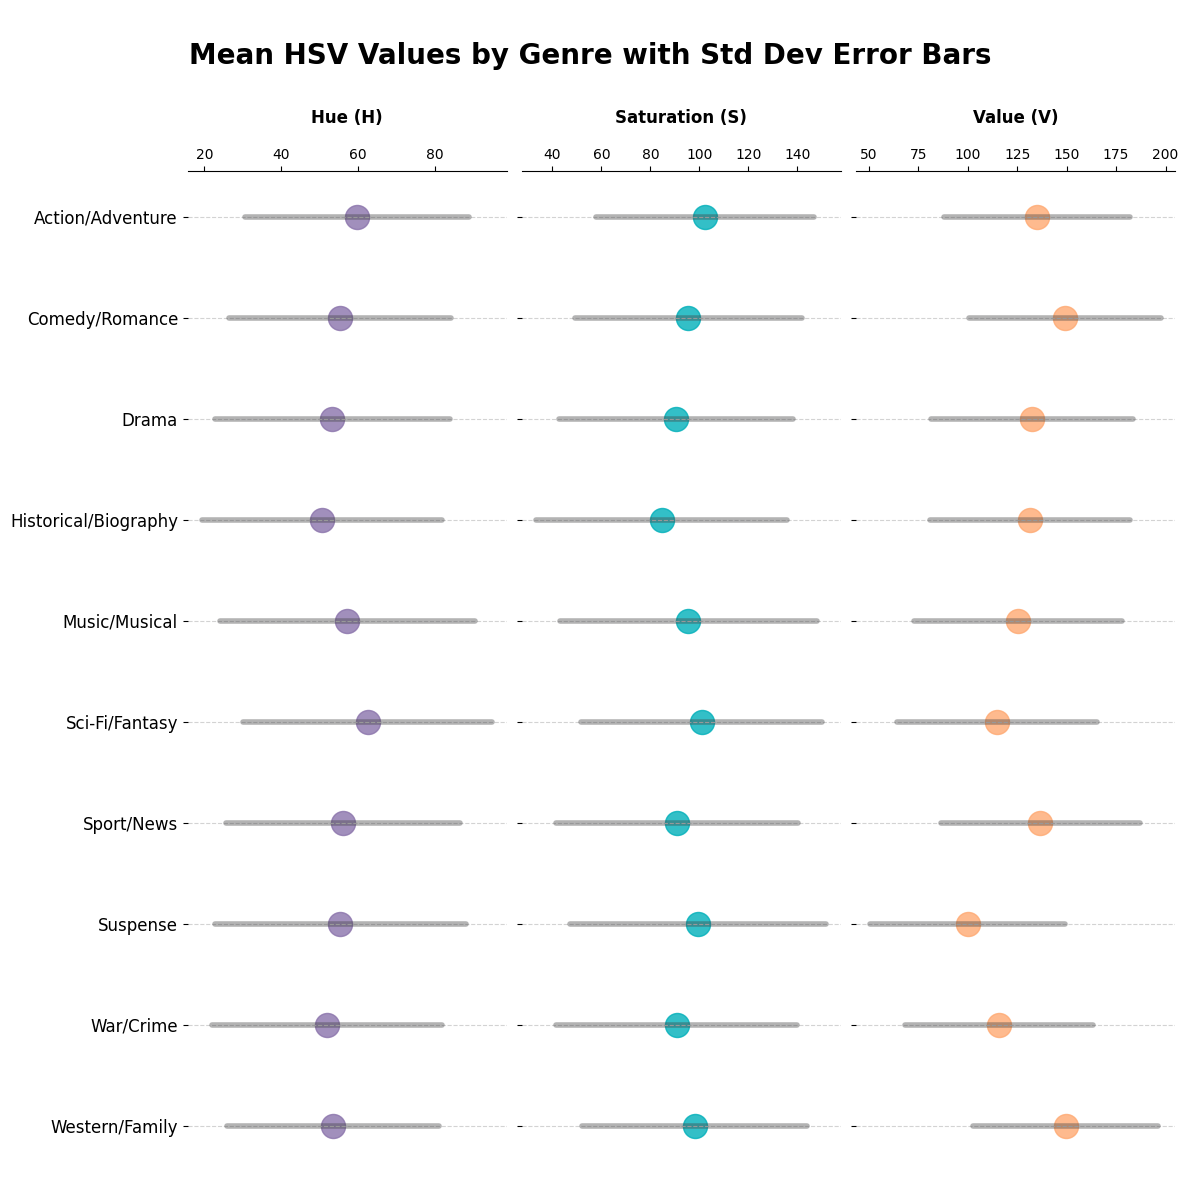

In [15]:
# Extract means and stds
means = avg_hsv_by_genre
stds = std_hsv_by_genre

genres = means.index.tolist()
y_pos = range(len(genres))

fig, axes = plt.subplots(1, 3, figsize=(12, 12), facecolor='none', sharey=True)

channels = ['mean_H', 'mean_S', 'mean_V']
titles = ['Hue (H)\n', 'Saturation (S)\n', 'Value (V)\n']

palette_2 = ['#8A73AB', '#00AFB9', '#FEA972']


for i, ax in enumerate(axes):

    # Set up the plot apparence
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.xaxis.tick_top()

    # Set light gray grid lines
    ax.grid(axis='y', color='lightgray', linestyle='--')
    ax.grid(axis='x', visible=False) 
    
    channel = channels[i]

    for y, genre in enumerate(genres):
        mean = means.loc[genre, channel]
        std = stds.loc[genre, channel]

        # Plot error bar as a line with rounded caps
        ax.plot([mean - std, mean + std], [y, y], lw=4, color='#414142', alpha=0.4, solid_capstyle='round')

        # Plot mean point
        ax.scatter(
            mean, y,
            marker='o',
            color=palette_2[i],
            alpha=0.8,
            s=300
        )

    ax.set_title(titles[i], size=12, weight = 'semibold', pad=20)
    

axes[0].set_yticks(y_pos)
axes[0].set_yticklabels(genres, size=12)
axes[0].tick_params(axis='y')
axes[0].invert_yaxis()
fig.suptitle('\nMean HSV Values by Genre with Std Dev Error Bars \n', fontsize=20, fontweight='heavy')
plt.tight_layout()
plt.savefig('Plots/Mean HSV Values by Genre with Std Dev Error Bars.png', dpi=300, transparent=True)
plt.show()

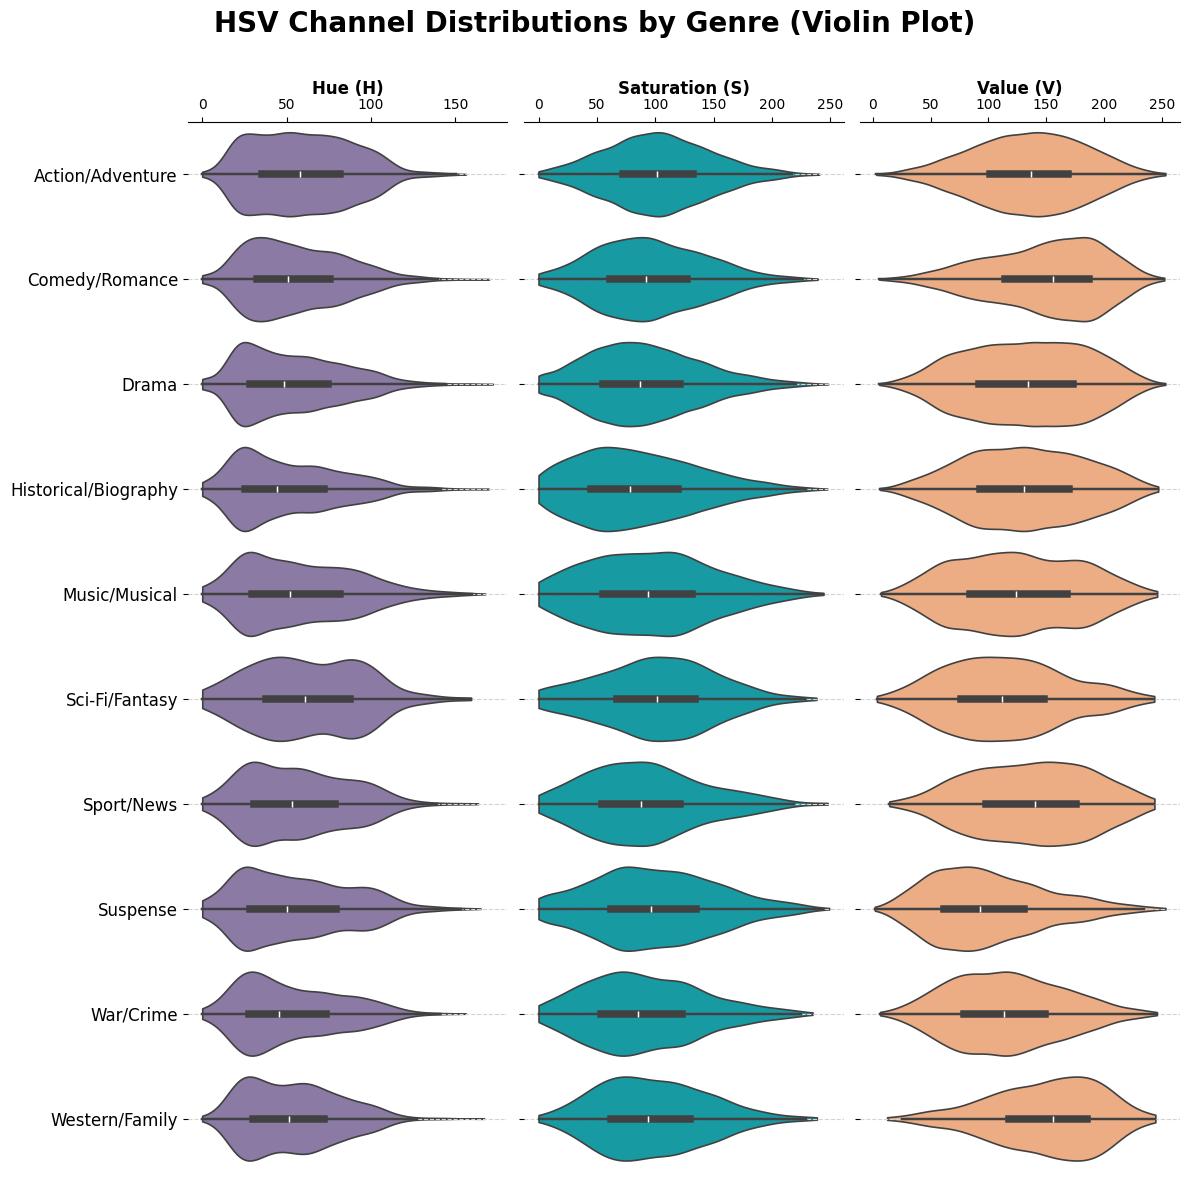

In [17]:

# Prepare data for violin plots
df_violin = hsv_feature[['labels', 'mean_H', 'mean_S', 'mean_V']].copy()
df_violin = df_violin.rename(columns={
    'mean_H': 'Hue (H)',
    'mean_S': 'Saturation (S)',
    'mean_V': 'Value (V)'
})

# Melt to long format
df_melted = df_violin.melt(id_vars='labels', var_name='Channel', value_name='Value')

# Plot
fig, axes = plt.subplots(1, 3, figsize=(12, 12), sharey=True)

channels = ['Hue (H)', 'Saturation (S)', 'Value (V)']

# Compute sorting order by average hue
genre_order = sorted(
    df_violin.groupby('labels')["Hue (H)"]
    .mean()
    .index.tolist(), reverse=True
)

for i, channel in enumerate(channels):

    ax = axes[i]

    sns.violinplot(
        data=df_melted[df_melted['Channel'] == channel],
        y='labels',
        x='Value',
        density_norm='width',
        order=genre_order,
        linewidth=1.2,
        cut=0,
        ax=ax,
        linecolor='#414142',
        color=palette_2[i]
    )


    ax.set_title(channel, fontsize=12, weight='semibold', pad=20)
    
    ax.spines[['bottom', 'right', 'left']].set_visible(False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.invert_yaxis()
    ax.grid(axis='y', color='lightgray', linestyle='--')
    ax.grid(axis='x', visible=False) 

    ax.xaxis.tick_top()
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=12)

fig.suptitle('HSV Channel Distributions by Genre (Violin Plot)', fontsize=20, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('Plots/HSV Violin Plots by Genre.png', dpi=300, transparent=True)
plt.show()

**1.4.2 H, S, V histograms by movie genre**

In [19]:
hsv_feature['hue_hist'] = hsv_feature['hsv_histogram'].apply(lambda x: x[0:32])

In [21]:
hsv_feature.head()

tconst                labels  \
0   tt3608918              Suspense   
1  tt28378602                 Drama   
2  tt27129223        Sci-Fi/Fantasy   
3  tt15173938              Suspense   
4  tt10508276  Historical/Biography   

                                       hsv_histogram     mean_H      std_H  \
0  [0.33420834, 0.0049166665, 0.0029416666, 0.002...  63.405925  50.408507   
1  [0.07063334, 0.11569167, 0.16465832, 0.15445, ...  63.808933  57.506773   
2  [0.6053167, 0.0012, 0.0008916667, 0.0001666666...  53.212408  72.751655   
3  [0.062258337, 0.16750833, 0.25995, 0.016058333...  55.952642  47.371237   
4  [0.106258325, 0.21510834, 0.22796667, 0.365208...  16.362842  18.130544   

     skew_H      mean_S       std_S    skew_S      mean_V      std_V  \
0 -0.053310  143.402875  105.626103 -0.290273   53.268092  88.553252   
1  0.433350  100.829558   57.509037  1.040063  105.326600  65.718530   
2  0.831757   95.303733  112.414287  0.531609   21.114508  53.386910   
3  0.235271  153.266808   64.892503 -0.910692  122.929158  60.197358   
4  7.185012  210.625358   47.828171 -1.674135  109.771950  76.593402   

     skew_V                                           hue_hist  \
0  1.510942  [0.33420834, 0.0049166665, 0.0029416666, 0.002...   
1  0.218867  [0.07063334, 0.11569167, 0.16465832, 0.15445, ...   
2  3.015192  [0.6053167, 0.0012, 0.0008916667, 0.0001666666...   
3 -0.123497  [0.062258337, 0.16750833, 0.25995, 0.016058333...   
4  0.274754  [0.106258325, 0.21510834, 0.22796667, 0.365208...   

                                     saturation_hist  \
0  [0.27296668, 0.0012416666, 0.0027000003, 0.004...   
1  [0.0048166667, 0.009225, 0.016641667, 0.023816...   
2  [0.5135751, 0.0007833333, 0.0020833334, 0.0045...   
3  [0.03315, 0.03234167, 0.021466667, 0.014925, 0...   
4  [0.00085000007, 0.001516667, 0.0015916668, 0.0...   

                                          value_hist  
0  [0.54963315, 0.10475816, 0.041008424, 0.023250...  
1  [0.055833396, 0.04039177, 0.028900063, 0.04814...  
2  [0.74047494, 0.072525054, 0.032800008, 0.02015...  
3  [0.0028833312, 0.009558357, 0.023583392, 0.042...  
4  [0.01127501, 0.049483404, 0.09754949, 0.064166...

In [23]:
def fix_and_parse_array(x):
    if isinstance(x, str):
        # Remove square brackets and replace spaces with commas
        fixed = re.sub(r'\s+', ',', x.strip("[]"))
        return np.fromstring(fixed, sep=',')
    return x  # if already a NumPy array

# Apply to all three histogram columns
hsv_feature['hue_hist'] = hsv_feature['hue_hist'].apply(fix_and_parse_array)
hsv_feature['saturation_hist'] = hsv_feature['saturation_hist'].apply(fix_and_parse_array)
hsv_feature['value_hist'] = hsv_feature['value_hist'].apply(fix_and_parse_array)

In [25]:
# Helper function to average lists of arrays
def average_histograms(hist_series):
    return np.mean(np.stack(hist_series.values), axis=0)

# Group and apply
avg_hue_by_genre = hsv_feature.groupby('labels')['hue_hist'].apply(average_histograms)
avg_sat_by_genre = hsv_feature.groupby('labels')['saturation_hist'].apply(average_histograms)
avg_val_by_genre = hsv_feature.groupby('labels')['value_hist'].apply(average_histograms)

In [27]:
# Turn each histogram series into long-form DataFrame
def melt_histograms(avg_hist_series, channel_name):
    data = []
    for genre, hist in avg_hist_series.items():
        for i, val in enumerate(hist):
            x = i / len(hist)  # Normalize to 0–1
            n_samples = int(val * 1000)  # Convert to sample density
            data.extend([(genre, channel_name, x)] * n_samples)
    return pd.DataFrame(data, columns=["Genre", "Channel", "Value"])

# Combine all three color channels
df_hue = melt_histograms(avg_hue_by_genre, "Hue")
df_sat = melt_histograms(avg_sat_by_genre, "Saturation")
df_val = melt_histograms(avg_val_by_genre, "Value")
df_all = pd.concat([df_hue, df_sat, df_val], ignore_index=True)

In [29]:
# Ensure consistent genre order
genre_order = sorted(avg_hue_by_genre.index.tolist(), reverse=False)
df_all["Genre"] = pd.Categorical(df_all["Genre"], categories=genre_order, ordered=True)


In [31]:
# Define color gradients
gradients = [["#8A73AB","#9783B4","#A492BE","#B1A2C7","#BEB1D0","#CBC1DA","#D8D0E3","#E5E0EC","#F2EFF6","#FFFFFF"],
             ["#00AFB9","#1CB8C1","#39C1C9","#55CAD0","#71D3D8","#8EDBE0","#AAE4E8","#C6EDEF","#E3F6F7",'#FFFFFF'],
             ["#FEA972","#FEB382","#FEBC91","#FEC6A1","#FECFB1","#FFD9C0","#FFE2D0","#FFECE0","#FFF5EF",'#FFFFFF']
            ]

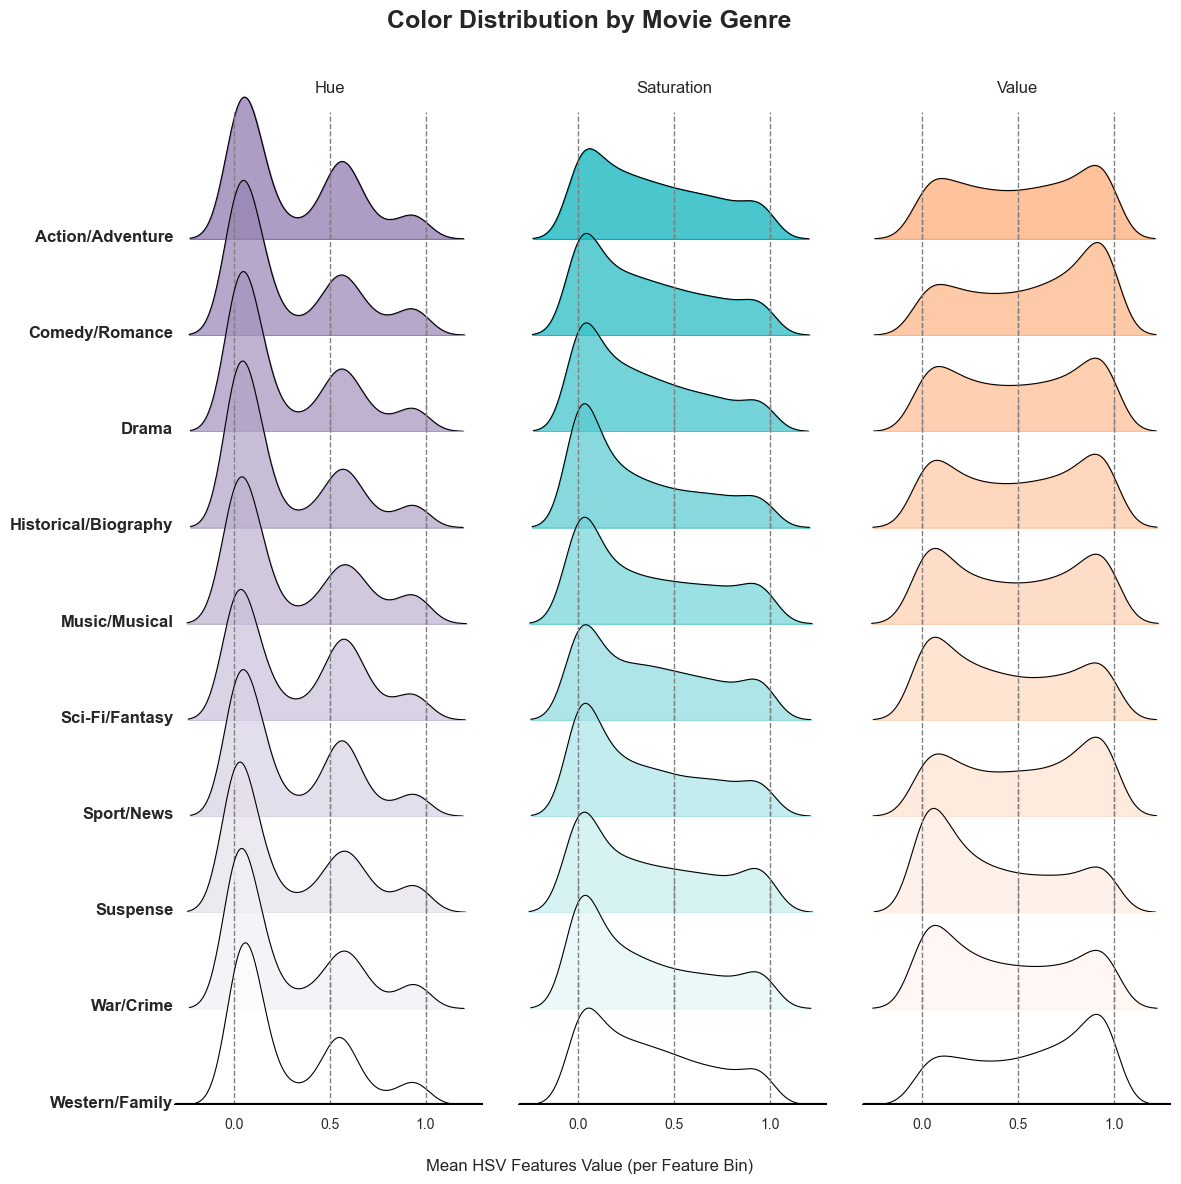

In [33]:
# Set up FacetGrid-like layout using subplots
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

fig, axes = plt.subplots(
    nrows=len(genre_order),
    ncols=3,
    figsize=(12, 12),
    sharey=True,
    sharex=True
)

channel_titles = ["Hue", "Saturation", "Value"]

for j, channel in enumerate(channel_titles):
    for i, genre in enumerate(genre_order):
        ax = axes[i, j]
        subset = df_all[(df_all["Channel"] == channel) & (df_all["Genre"] == genre)]
        
        # Filled KDE
        sns.kdeplot(
            data=subset,
            x="Value",
            fill=True,
            alpha=0.7,
            ax=ax,
            color=gradients[j][i]
        )
        
        # Outline
        sns.kdeplot(
            data=subset,
            x="Value",
            fill=False,
            ax=ax,
            color='black',
            linewidth=0.8
        )

        # Style
        ax.set_xlim(-0.4, 1.3)
        ax.set_xticks([0, 0.5, 1])
        ax.set_yticks([])
        ax.set_ylabel("")
        ax.set_xlabel("")
        # ax.set_xlabel(f"Mean {channel_titles[j]} Feature Value", fontsize=12)

        # Add vertical guide at x=0.5
        ax.plot([0., 0.], [0., 2], linestyle='--', color='gray', linewidth=1)
        ax.plot([0.5, 0.5], [0., 2], linestyle='--', color='gray', linewidth=1)
        ax.plot([1., 1.], [0., 2], linestyle='--', color='gray', linewidth=1)

        # Genre label on the left
        if j == 0:
            ax.text(0.05, 0.01, genre, fontsize=12, weight="semibold", va="center", ha="right", transform=ax.transAxes)

        # # Column titles
        # if i == 0:
        #     ax.set_title(channel_titles[j], fontsize=12, weight='semibold', y=0.8)

        # Clean up axes
        ax.spines[['top', 'right', 'left']].set_visible(False)
        ax.tick_params(axis='x', labelsize=10)

    axes[0, j].text(0.5, 2.5, channel, fontsize=12, va="top", ha="center")
    axes[-1, j].plot([-0.3, 1.3], [0, 0], lw=3, color='black')

# Final layout tweaks
# plt.subplots_adjust(wspace=0.1, hspace=-0.55)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(hspace=-0.45)
sns.despine(left=True, bottom=True)


sns.despine(left=True, bottom=True)
fig.supxlabel("Mean HSV Features Value (per Feature Bin)", fontsize=12)
fig.suptitle("Color Distribution by Movie Genre", fontsize=18, weight='bold')
plt.savefig('Plots/Color Distribution by Movie Genre (Hue, Saturation, Value).png', transparent=True)
plt.show()

**1.4.3 Posters with the highest/lowest feature values**

In [35]:
# check min and max values
max_value_row = hsv_feature.loc[hsv_feature['mean_V'].idxmax()]
max_value_row

tconst                                                    tt14926354
labels                                                      Suspense
hsv_histogram      [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
mean_H                                                           0.0
std_H                                                            0.0
skew_H                                                           NaN
mean_S                                                           0.0
std_S                                                            0.0
skew_S                                                           NaN
mean_V                                                    253.257508
std_V                                                       15.78637
skew_V                                                    -11.074816
hue_hist           [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
saturation_hist    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
value_hist         [0.00033333333,

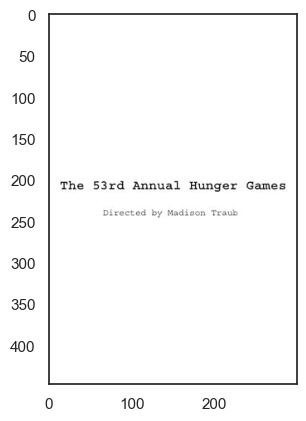

In [37]:
image_path = 'Data/WithText/tt14926354.jpg'
image = Image.open(image_path)
plt.imshow(image)

In [39]:
min_value_row = hsv_feature.loc[hsv_feature['mean_V'].idxmin()]
min_value_row

tconst                                                     tt2149532
labels                                                      Suspense
hsv_histogram      [0.93192506, 0.00053333334, 0.0010666667, 0.00...
mean_H                                                      2.008883
std_H                                                       7.648251
skew_H                                                      4.471142
mean_S                                                      8.594017
std_S                                                      39.887734
skew_S                                                      5.165182
mean_V                                                      1.798508
std_V                                                      14.745924
skew_V                                                     12.612335
hue_hist           [0.93192506, 0.00053333334, 0.0010666667, 0.00...
saturation_hist    [0.9346166, 0.004466667, 0.0049333335, 0.00370...
value_hist         [0.9702251, 0.0

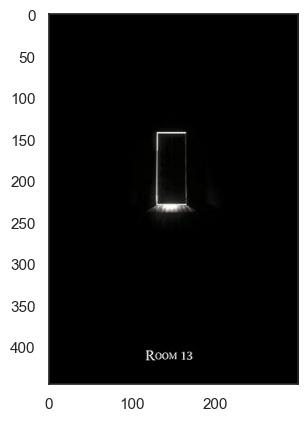

In [41]:
image_path = 'Data/WithText/tt2149532.jpg'
image = Image.open(image_path)
plt.imshow(image)

### **1.5 EDA of HOG Features**


In [43]:
hog_feature = pd.read_pickle("Features/classic_hog_features.pkl")
hog_feature = pd.DataFrame(hog_feature)

hog_feature['labels'] = hog_feature['labels'].apply(
    lambda x: str(x[0]) if isinstance(x, (list, np.ndarray)) else str(x)
)


In [45]:
hog_feature.head()

tconst                labels  \
0   tt3608918              Suspense   
1  tt28378602                 Drama   
2  tt27129223        Sci-Fi/Fantasy   
3  tt15173938              Suspense   
4  tt10508276  Historical/Biography   

                                            features  
0  [0.41017407120533755, 0.2229771089925445, 0.21...  
1  [0.4110451335525371, 0.4110451335525371, 0.201...  
2  [0.3831175742075968, 0.3831175742075968, 0.383...  
3  [0.3925073843816495, 0.3925073843816495, 0.392...  
4  [0.36486036563103447, 0.36486036563103447, 0.3...

In [47]:
# Convert list of lists into 2D NumPy array
hog_matrix = np.stack(hog_feature['features'].values)

# Turn into a DataFrame with labeled genres
hog_df = pd.DataFrame(hog_matrix)
hog_df['Genre'] = hog_feature['labels']

In [49]:
# Movie examples
movies = [
    ("tt0070047", "Suspense"),
    ("tt0083658", "Sci-Fi/Fantasy"),
    ("tt0068646", "War/Crime"),
    ("tt0108052", "Historical/Biography"),
    ("tt0118694", "Comedy/Romance"),
    ("tt0110912", "Drama"),
    ("tt0270971", "Sport/News"),
    ("tt0120903", "Action/Adventure"),
    ("tt0332379", "Music/Musical"),
    ("tt12240332", "Western/Family")
]


**1.5.1 HOG and HSV images examples**

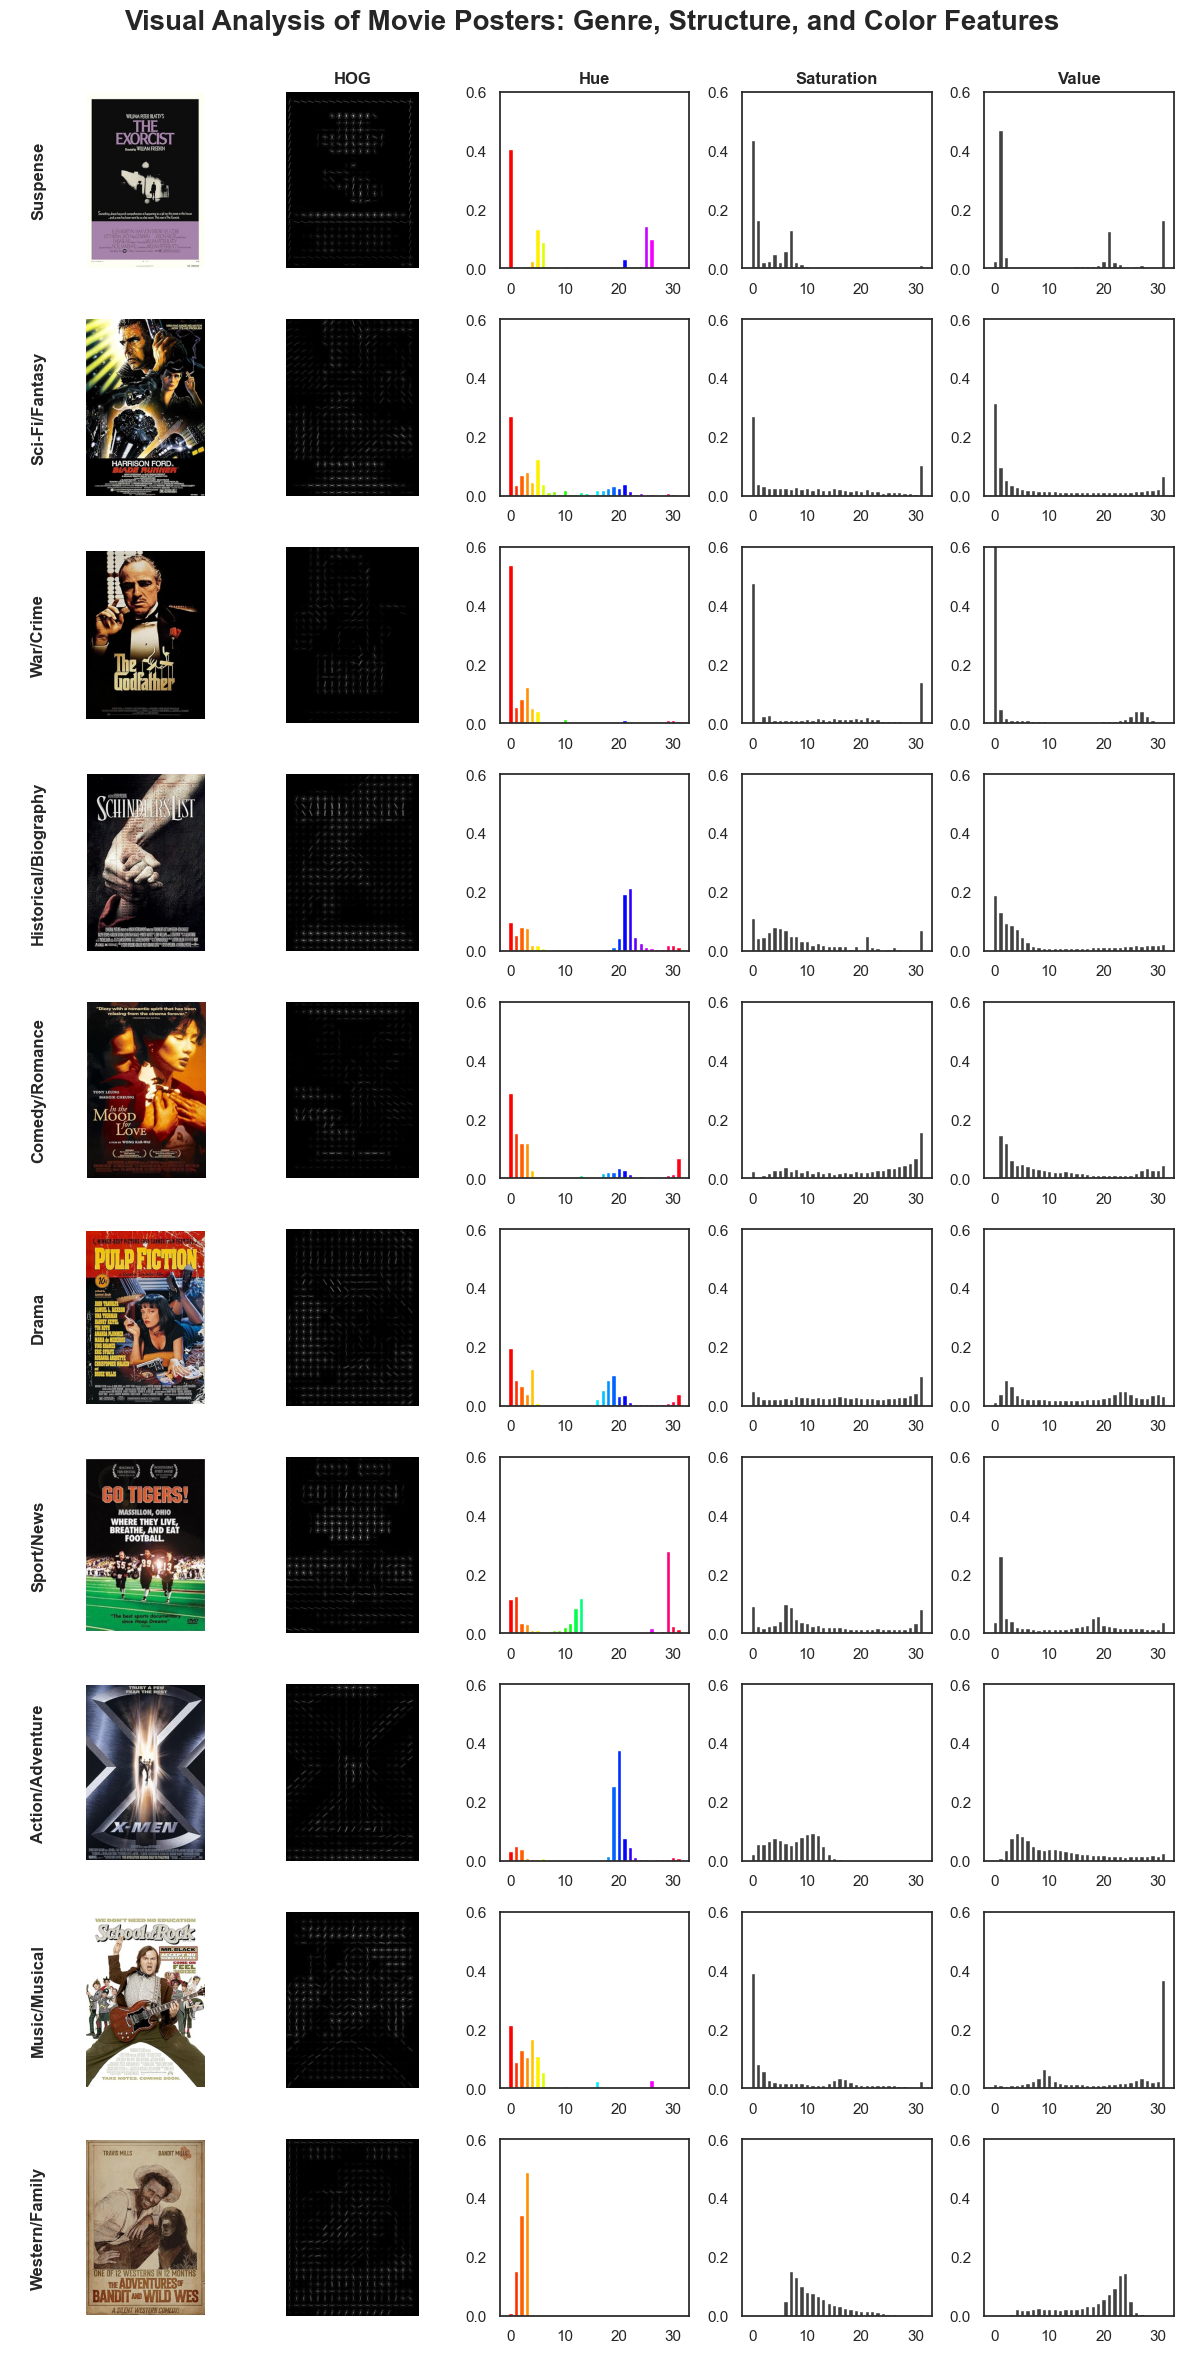

In [51]:
# Paths
original_dir = "Data/WithText"
hog_dir = "Data/HOG"

# Set up the plot
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
fig, axs = plt.subplots(10, 6, figsize=(12, 24), width_ratios=[0.5, 2.5, 4, 4, 4, 4])

colors = np.linspace(0, 360, 32)
cmap = plt.cm.hsv

bins=32

for i, (movie_id, genre) in enumerate(movies):
    
    # Load images
    original_path = os.path.join(original_dir, f"{movie_id}.jpg")
    hog_path = os.path.join(hog_dir, f"{movie_id}.jpg")

    original_img = cv2.imread(original_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    hog_img = cv2.imread(hog_path, cv2.IMREAD_GRAYSCALE)

    # Extract HSV histograms
    hue = hsv_feature[hsv_feature.tconst == movie_id]['hue_hist'].values[0]
    saturation = hsv_feature[hsv_feature.tconst == movie_id]['saturation_hist'].values[0]
    value = hsv_feature[hsv_feature.tconst == movie_id]['value_hist'].values[0]

    axs[i, 0].text(
        1.2, 0.5, genre,
        fontsize=12, weight='semibold',
        va="center", ha="center", rotation='vertical'
    )
    axs[i, 0].axis('off')

    # Plot original image
    axs[i, 1].imshow(original_img)
    axs[i, 1].axis('off')

    # Plot HOG
    axs[i, 2].imshow(hog_img, cmap='gray')
    axs[i, 2].axis('off')

    # Plot HSV histograms
    axs[i, 3].bar(np.arange(bins), hue, color=cmap(colors / 360))
    axs[i, 3].set_ylim(0, 0.6)
    
    axs[i, 4].bar(np.arange(len(saturation)), saturation, color="#414142")
    axs[i, 4].set_ylim(0, 0.6)
    
    axs[i, 5].bar(np.arange(len(value)), value, color="#414142")
    axs[i, 5].set_ylim(0, 0.6)

    if i ==0:
        axs[i, 2].set_title('HOG', fontsize=12, weight='semibold')
        axs[i, 3].set_title('Hue', fontsize=12, weight='semibold')
        axs[i, 4].set_title('Saturation', fontsize=12, weight='semibold')
        axs[i, 5].set_title('Value', fontsize=12, weight='semibold')
        

# fig.subplots_adjust(hspace=0.9, wspace=0.5)
plt.suptitle("Visual Analysis of Movie Posters: Genre, Structure, and Color Features", fontsize=20, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig('Plots/genre examples.png', dpi=300, transparent=True)
plt.show()



**1.5.2 Violin Plots (Selected HOG Features by Genre)**  


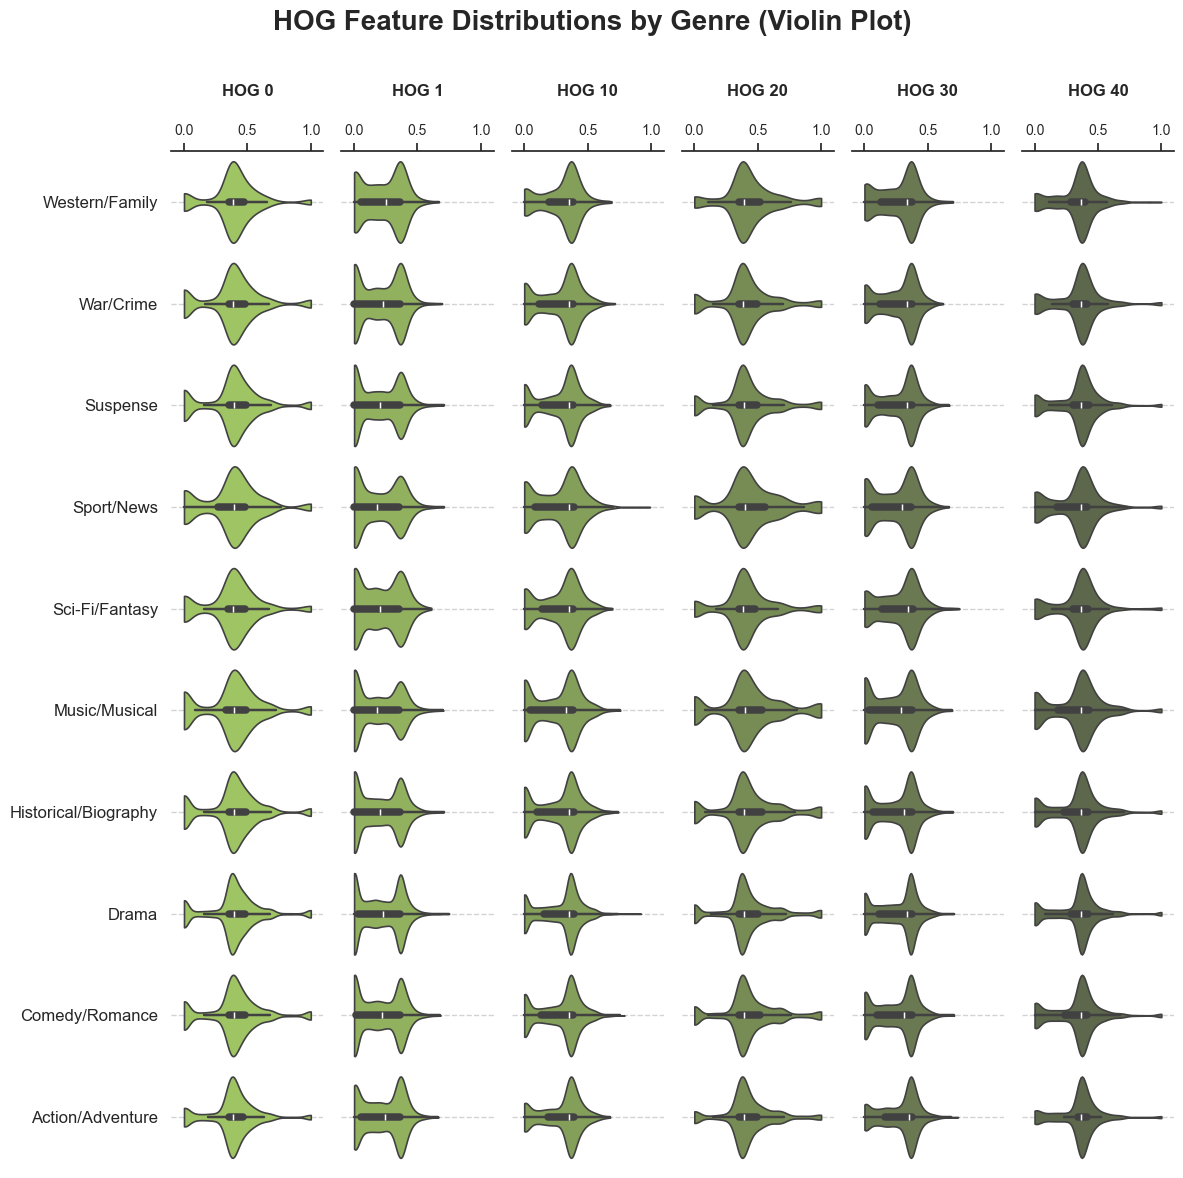

In [53]:

# Step 1: Prepare data
selected_features = [0, 1, 10, 20, 30, 40]
hog_melted = hog_df.melt(id_vars='Genre', value_vars=selected_features,
                         var_name='HOG Feature', value_name='Value')

# Step 2: Rename HOG Feature labels to be more readable
feature_labels = {i: f'HOG {i}' for i in selected_features}
hog_melted['HOG Feature'] = hog_melted['HOG Feature'].astype(int).map(feature_labels)

# Step3: Plot

palette = [
"#A3D454","#95BF51","#87AA4F","#79954C","#6B804A","#5D6B47","#4F5645","#414142"
]

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

fig, axes = plt.subplots(1, 6, figsize=(12, 12), sharey=True)

channels = ['HOG 0', 'HOG 1', 'HOG 10', 'HOG 20', 'HOG 30', 'HOG 40']


for i, channel in enumerate(channels):
    ax = axes[i]

    sns.violinplot(
        data=hog_melted[hog_melted['HOG Feature'] == channel],
        y='Genre',
        x='Value',
        density_norm='width',
        order=genre_order,
        linewidth=1.2,
        cut=0,
        ax=ax,
        linecolor='#414142',
        color = palette[i]
    )


    ax.set_title(channel, fontsize=12, weight='semibold', pad=20)
    ax.spines[['bottom', 'right', 'left']].set_visible(False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.invert_yaxis()
    ax.grid(axis='y', color='lightgray', linestyle='--')
    ax.grid(axis='x', visible=False) 
    ax.set_xlim(-0.1, 1.1)
    ax.set_xticks([0.0, 0.5, 1.0])

    ax.xaxis.tick_top()
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=12)


fig.suptitle('HOG Feature Distributions by Genre (Violin Plot)', fontsize=20, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('Plots/HOG Violin Plots by Genre.png', dpi=300, transparent=True)
plt.show()

**1.5.3 Correlation Heatmap (Top N Features)**

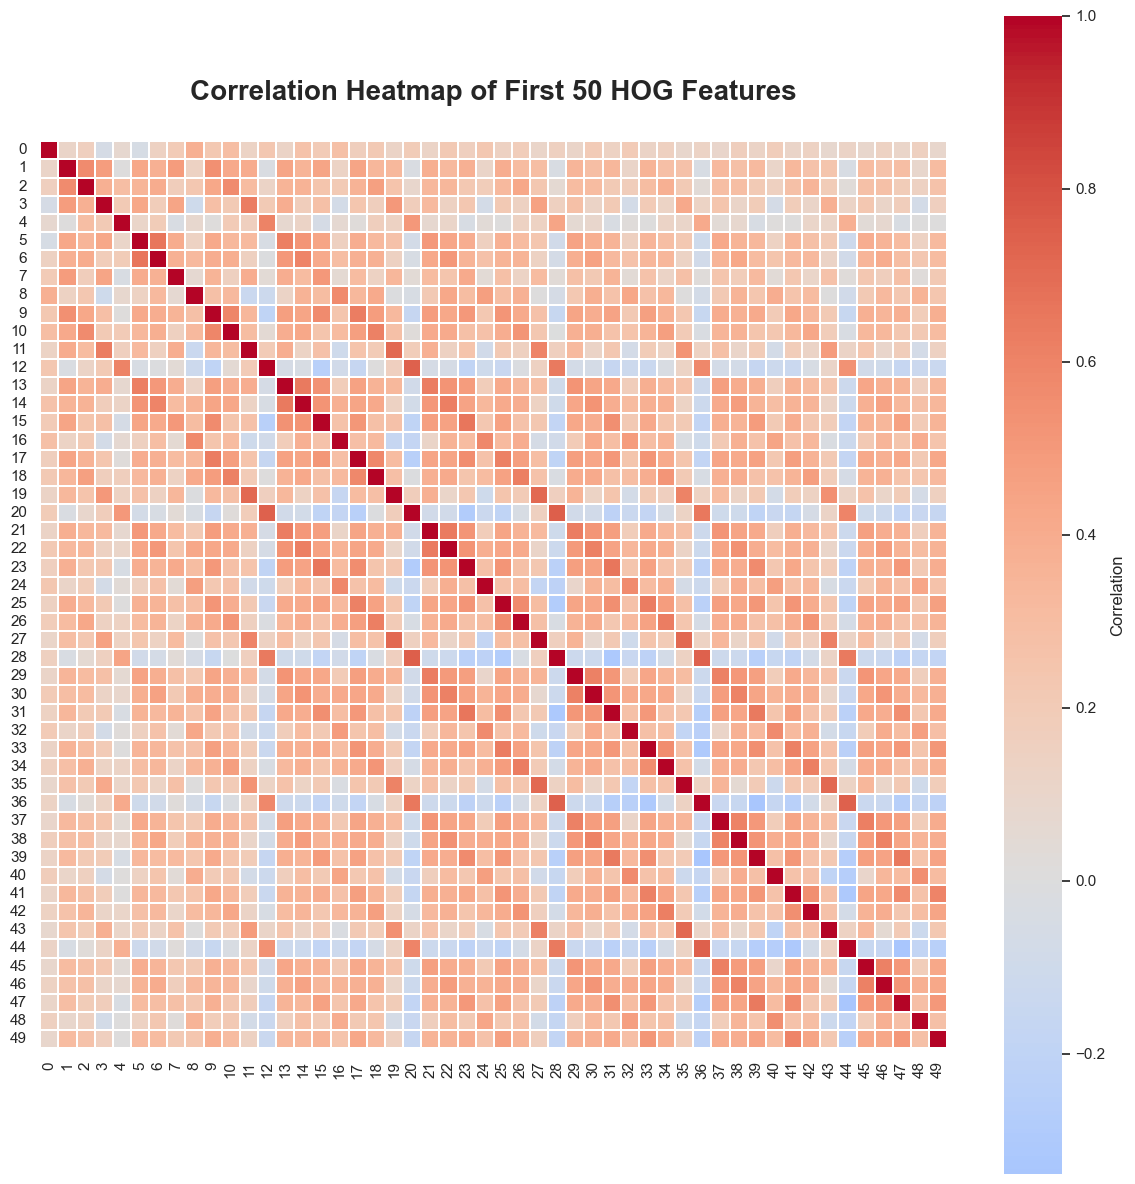

In [55]:
# Choose number of features to show
n_features = 50
corr_matrix = np.corrcoef(hog_matrix.T[:n_features])

plt.figure(figsize=(12, 12))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    xticklabels=range(n_features),
    yticklabels=range(n_features),
    square=True,
    linewidths=0.1,
    cbar_kws={'label': 'Correlation'}
)
plt.title(f'Correlation Heatmap of First {n_features} HOG Features', fontsize=20, weight='bold', pad=30)
plt.tight_layout()
plt.savefig('Plots/HOG_Correlation_Heatmap.png', dpi=300, transparent=True)
plt.show()

Include PCA, t-SNE and save the vectors for classification

**1.5.4 PCA and t-SNE Plots**

In [69]:
# HSV Features
hsv_df = pd.read_pickle("Features/classic_hsv_features_named.pkl")
hsv_df = pd.DataFrame(hsv_df)

features_df = hsv_df['features'].apply(pd.Series)

hsv_feature = pd.concat([hsv_df.drop(columns=['features']), features_df], axis=1)
hsv_feature['labels'] = hsv_feature['labels'].apply(lambda x: str(x[0]) if isinstance(x, (list, np.ndarray)) else str(x))
hsv_feature['hue_hist'] = hsv_feature['hsv_histogram'].apply(lambda x: x[:32])
hsv_feature['saturation_hist'] = hsv_feature['hsv_histogram'].apply(lambda x: x[32:64])
hsv_feature['value_hist'] = hsv_feature['hsv_histogram'].apply(lambda x: x[64:])

hsv_matrix = np.stack(hsv_feature['hsv_histogram'].values)
hsv_labels = hsv_feature['labels'].values

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(hsv_feature['labels'])

In [71]:
# HOG Features
hog_df = pd.read_pickle("Features/classic_hog_features.pkl")
hog_df = pd.DataFrame(hog_df)
hog_df['labels'] = hog_df['labels'].apply(lambda x: str(x[0]) if isinstance(x, (list, np.ndarray)) else str(x))
hog_matrix = np.stack(hog_df['features'].values)
hog_labels = hog_df['labels'].values

In [59]:
def compute_pca_tsne(features, 
                     n_components=0.95, 
                     tsne_perplexity=30, 
                     random_state=42, 
                     pickle_prefix="pca_tsne"):
    """
    Computes PCA and t-SNE on the input features after applying StandardScaler.
    
    Parameters:
      features (ndarray): The feature matrix (n_samples x n_features).
      n_components (float or int): If float, the fraction of variance to retain 
                                   by PCA; if int, the fixed number of components.
      tsne_perplexity (int): The perplexity parameter for t-SNE.
      random_state (int): Random state for reproducibility.
      pickle_prefix (str): Prefix for naming the pickle files.
      
    Returns:
      features_tsne (ndarray): The 2D t-SNE representation of the (PCA-reduced) features.
    """
    # Step 1: Standard scaling
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # Save the scaler for future use
    with open(f"{pickle_prefix}_scaler.pkl", "wb") as f:
        pickle.dump(scaler, f)
    
    # Step 2: PCA computation on the scaled data
    pca = PCA(n_components=n_components)
    features_pca = pca.fit_transform(features_scaled)
    
    # Save the PCA object
    with open(f"{pickle_prefix}_pca.pkl", "wb") as f:
        pickle.dump(pca, f)
    
    # Step 3: t-SNE computation on the PCA-reduced data
    tsne = TSNE(n_components=2, perplexity=tsne_perplexity, random_state=random_state)
    features_tsne = tsne.fit_transform(features_pca)
    
    # Save the t-SNE object and computed t-SNE features
    with open(f"{pickle_prefix}_tsne.pkl", "wb") as f:
        pickle.dump(tsne, f)
    with open(f"{pickle_prefix}_features_tsne.pkl", "wb") as f:
        pickle.dump(features_tsne, f)
    
    return features_tsne

In [61]:
def tsne_plot(features_tsne, labels, title_prefix):
    
    df_tsne = pd.DataFrame(features_tsne, columns=['TSNE1', 'TSNE2'])
    df_tsne['Label'] = labels
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Label', palette='tab10', s=60, alpha=0.7)
    plt.title(f"{title_prefix} - t-SNE on PCA-Reduced Features", fontsize=14)
    plt.legend(loc='best', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()

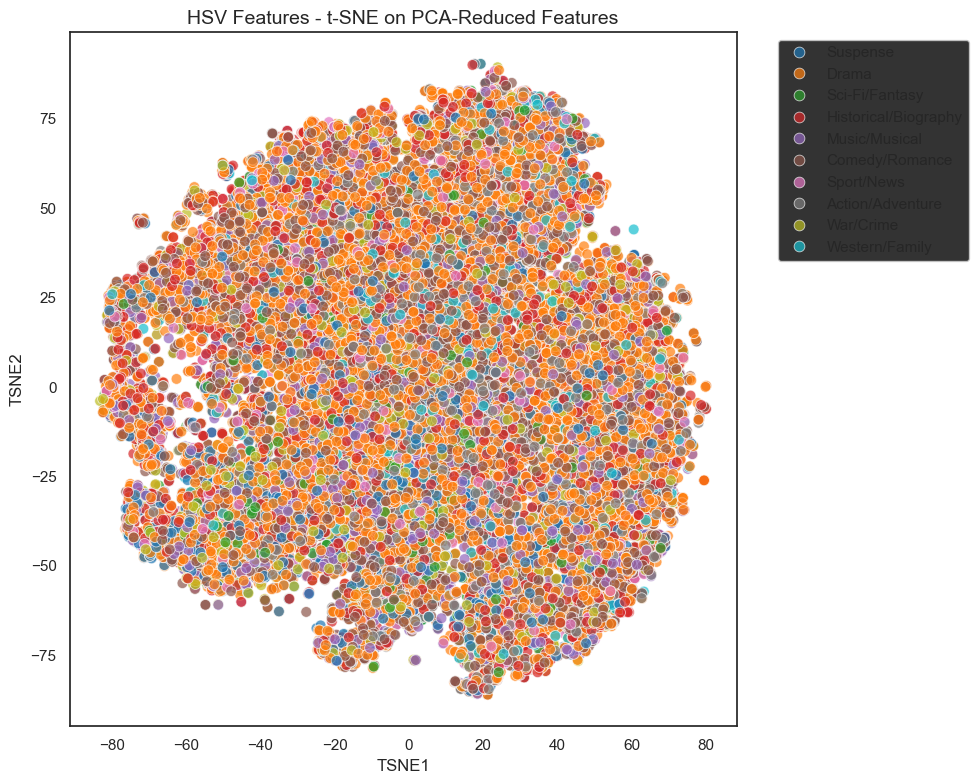

In [73]:
# hsv_tsne = compute_pca_tsne(hsv_matrix, pickle_prefix='hsv')
hsv_tsne = pd.read_pickle("Features/hsv_features_tsne.pkl")
tsne_plot(hsv_tsne, hsv_labels, "HSV Features")

In [75]:
# hog_tsne = compute_pca_tsne(hog_matrix, pickle_prefix='hog')
hog_tsne = pd.read_pickle("Features/hog_features_tsne.pkl")

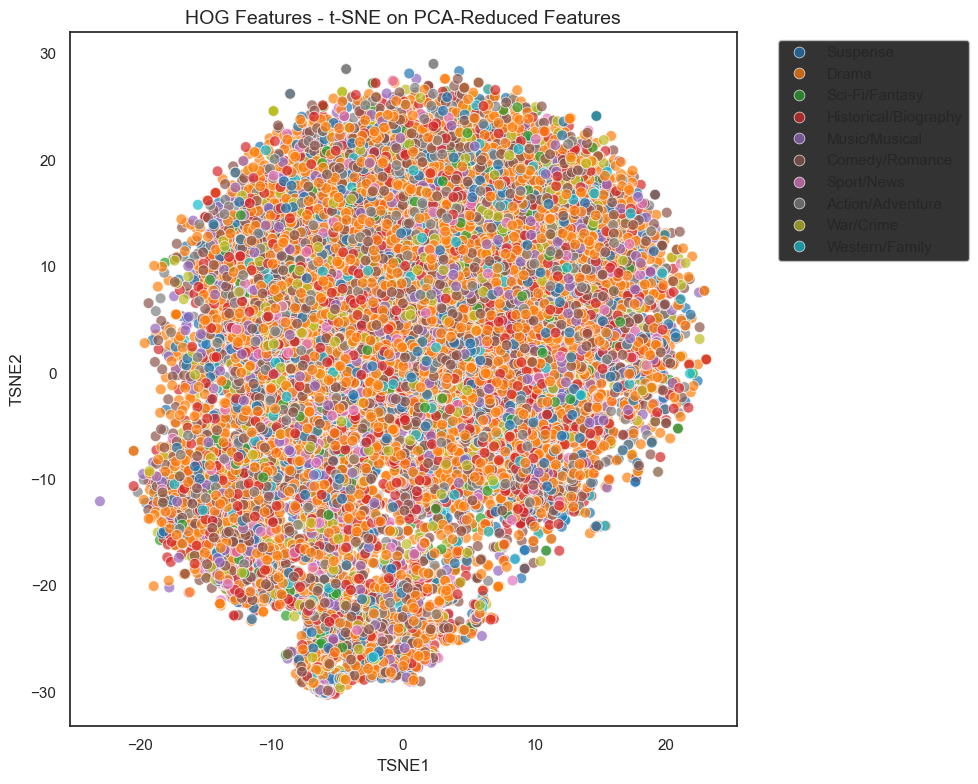

In [76]:
tsne_plot(hog_tsne, hsv_labels, "HOG Features")

In [ ]:
pca = PCA(n_components=0.85)
hog_pca = pca.fit_transform(hog_matrix)

In [ ]:
df_pca = pd.DataFrame({
    'PCA1': hog_pca[:, 0],
    'PCA2': hog_pca[:, 1],
    'PCA3': hog_pca[:, 2],
    'PCA4': hog_pca[:, 3],
    'PCA5': hog_pca[:, 4],
    'PCA6': hog_pca[:, 5],
    'PCA7': hog_pca[:, 6],
    'PCA8': hog_pca[:, 7],
    'PCA9': hog_pca[:, 8],
    'PCA10': hog_pca[:, 9],
    'Genre': hog_feature['labels']
})

In [ ]:
df_pca.to_pickle('Features/hog_pca_vectors.pkl')

In [ ]:
# tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
# hog_tsne = tsne.fit_transform(hog_matrix)

In [ ]:
# df_tsne = pd.DataFrame({
#     'TSNE1': hog_tsne[:, 0],
#     'TSNE2': hog_tsne[:, 1],
#     'Genre': hog_feature['labels']
# })

In [ ]:
# df_tsne.to_pickle('Features/hog_tsne_vectors.pkl')

In [ ]:
df_pca = pd.read_pickle('Features/hog_pca_vectors.pkl')

In [ ]:
df_tsne = pd.read_pickle('Features/hog_tsne_vectors.pkl')

In [ ]:
df_pca.head()

In [ ]:
sns.pairplot(df_pca, hue='Genre')

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Genre', palette='tab10', alpha=0.7)
plt.title('t-SNE Projection of HOG Features by Genre')
plt.tight_layout()
plt.show()

**1.5.5 Histogram of Mean HOG Feature Values by Genre**

In [ ]:
# --- Compute per-genre means ---
mean_profiles = hog_df.groupby('Genre').mean()

# --- Sort genres by average HOG intensity ---
genre_order = mean_profiles.mean(axis=1).sort_values(ascending=False).index.tolist()

# --- Define custom color palette ---
palette = ["#A3D454", "#ADD967", "#B7DE7A", "#C2E28D", "#CCE7A0",
           "#D6ECB3", "#E0F1C6", "#EBF5D9", "#F5FAEC", "#FFFFFF"]

# --- Global mean across all genres ---
global_mean = mean_profiles.values.mean()

# --- Set up subplots ---
fig, axes = plt.subplots(
    nrows=len(genre_order),
    ncols=1,
    figsize=(12, 12),
    sharex=True
)

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# --- KDE plotting ---
for i, genre in enumerate(genre_order):
    ax = axes[i]
    values = mean_profiles.loc[genre].values
    genre_mean = values.mean()

    # Filled KDE
    sns.kdeplot(
        x=values,
        fill=True,
        alpha=0.7,
        linewidth=0,
        ax=ax,
        color=palette[i]
    )

    # Outline
    sns.kdeplot(
        x=values,
        fill=False,
        linewidth=0.8,
        ax=ax,
        color='black'
    )

    # Add vertical lines for genre mean + global mean
    ax.axvline(global_mean, color='#A3D454', linestyle='-', linewidth=3)
    ax.axvline(genre_mean, color='black', linestyle='--', linewidth=1)

    # Style
    ax.set_xlim(0.1, 0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel("")
    ax.set_xlabel("")

    # Genre label on left
    ax.text(0.05, 0.01, genre, fontsize=12, weight='semibold', va="center", ha="right", transform=ax.transAxes)

# --- Final formatting ---
axes[-1].set_xticks([0.15, 0.25, 0.35, 0.45])
axes[-1].plot([0.15, 0.5], [0, 0], lw=3, color='black')

axes[0].plot([0.38, 0.39], [13, 13], color='#A3D454', linestyle='-', linewidth=3)
axes[0].text(0.395, 12.5, 'Overall mean across all genres', fontsize=12)

axes[0].plot([0.38, 0.39], [11, 11], color='black', linestyle='--', linewidth=1)
axes[0].text(0.395, 10.5, 'Mean within each genre', fontsize=12)


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(hspace=-0.45)
sns.despine(left=True, bottom=True)

fig.supxlabel("Mean HOG Feature Value (per Feature Bin)", fontsize=12)
fig.suptitle("Distribution of Mean HOG Features by Genre", fontsize=20, weight='bold')

# --- Save and show ---
plt.savefig("Plots/HOG_Mean_Feature_KDE_by_Genre_Improved.png", dpi=300, transparent=True)
plt.show()

**1.5.6 Average HOG Orientation Histogram by Genre**

In [ ]:
# CONFIG: Set number of orientation bins used when extracting HOG features
n_orientations = 8

# STEP 1: Extract HOG values (excluding the Genre column)
hog_values = hog_df.values  # shape: (n_samples, n_features)

# STEP 2: Reshape HOG features to [n_samples, n_cells, n_orientations]
n_features = hog_values.shape[1]
usable_features = (n_features // n_orientations) * n_orientations

hog_values_trimmed = hog_values[:, :usable_features]
n_cells = usable_features // n_orientations

hog_reshaped = hog_values_trimmed.reshape(-1, n_cells, n_orientations)

# STEP 3: Aggregate across cells → [n_samples, n_orientations]
hog_orient_summary = hog_reshaped.sum(axis=1)  # Sum over spatial cells

# STEP 4: Rebuild DataFrame with genres
hog_orient_df = pd.DataFrame(hog_orient_summary, columns=[f'{int(i*(180/n_orientations))}°' for i in range(n_orientations)])
hog_orient_df['Genre'] = hog_feature['labels'].values

# STEP 5: Group by genre and average
orient_by_genre = hog_orient_df.groupby('Genre').mean()

# STEP 6: Plot orientation histograms for each genre
angles = orient_by_genre.columns.tolist()
x = np.arange(len(angles))


In [ ]:
# 1. Prepare data (your centered DataFrame)
# Transpose so angles are on y-axis, and genres become "columns"
centered = orient_by_genre - orient_by_genre.mean()
centered_t = centered.T  # shape: (angles, genres)
centered_t.index.name = 'Angle'
centered_t.reset_index(inplace=True)

# 2. Melt for seaborn plotting
melted = centered_t.melt(id_vars='Angle', var_name='Genre', value_name='Δ Magnitude')

# 3. Sort angles numerically
melted['Angle'] = melted['Angle'].str.replace('°', '').astype(int)
melted = melted.sort_values('Angle')

# 4. Pivot the dataframe for plotting
melted_p = melted.pivot(index='Angle', columns='Genre', values='Δ Magnitude')

In [ ]:
orient_by_genre

In [ ]:
topics = melted_p.index
y_positions = np.arange(len(topics))
genre = melted_p.columns

# Prepare figure
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
fig, axes = plt.subplots(1, len(genre), figsize=(18, 24), sharey=True)

for j, genre in enumerate(genres):
    ax = axes[j]
    
    # Get deviation values for this genre
    values = melted_p[genre].values
    
    # Color code by value sign
    colors = ['#6CD292' if v >= 0 else '#fa3c4c' for v in values]
    
    # Plot horizontal bars
    ax.barh(
        y=y_positions,
        width=values,
        color=colors,
        edgecolor=colors,
        height=0.7
    )

    ax.set_xlim(-5, 5)
    
    # Add vertical reference line at 0
    ax.axvline(x=0, color='black', linewidth=1)
    
    # # Styling
    ax.set_title(genre, fontsize=10, weight='bold', pad=20)

    ax.spines[['right', 'left']].set_visible(False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.invert_yaxis()
    ax.grid(axis='x', visible=False) 

    ax.xaxis.tick_top()
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=12)
    
    # Set y-axis only on first plot
    if j == 0:
        ax.set_yticks(y_positions)
        ax.set_yticklabels([f"{a}°" for a in topics])
    # else:
    #     ax.set_yticks([])
    
    # Remove spines for clean look
    ax.grid(axis='y', color='lightgray', linestyle='--')

fig.suptitle("Deviation from Mean HOG Orientation Strength per Genre", fontsize=20, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig("Plots/Deviation from Mean HOG Orientation Strength per Genre.png", dpi=300, transparent=True)
plt.show()

## **Section 2: Advanced Feature Extraction**

This section uses advanced deep learning techniques to extract high-level features from the movie posters.

### Methods included:

- **Pretrained CNN (ResNet50)**: Use a pretrained ResNet50 model to obtain feature embeddings.
- **Vision Transformers (ViT)**: Extract image embeddings using a Vision Transformer model.

Each advanced method extracts features which are saved separately for further analysis and model development.

In [ ]:
# Import libraries for advanced feature extraction
# import torch
# import torchvision.models as models
# import torchvision.transforms as transforms
# import torch.nn as nn
# import torch.optim as optim

# from torchvision.datasets import ImageFolder
# from torch.utils.data import DataLoader

from transformers import ViTFeatureExtractor, ViTModel

In [ ]:
# if torch.backends.mps.is_available():
#     device = torch.device("mps")
# elif torch.cuda.is_available():
#     device = torch.device("cuda")
# else:
#     device = torch.device("cpu")

# print("Using device:", device)

### **2.1 Pretrained CNN (ResNet50)**

In [ ]:
# # Load pretrained ResNet50 model
# resnet50 = models.resnet50(weights=models.resnet.ResNet50_Weights.DEFAULT)

# # Remove the final classification layer to obtain feature embeddings
# feature_extractor = torch.nn.Sequential(*list(resnet50.children())[:-1])
# feature_extractor.to(device)
# feature_extractor.eval()

In [ ]:
# # Transformation pipeline (same as before)
# transform_pipeline = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
# ])

In [ ]:
# def resize_with_padding(image, target_size=(224, 224), fill_color=(0, 0, 0)):
#     """
#     Resize image while keeping aspect ratio and pad it to target size.
    
#     Args:
#         image (PIL.Image): The input image.
#         target_size (tuple): Desired output size (width, height).
#         fill_color (tuple): RGB color to use for padding.
    
#     Returns:
#         PIL.Image: Resized and padded image.
#     """
#     image.thumbnail(target_size, Image.Resampling.LANCZOS)
#     padded_image = Image.new("RGB", target_size, fill_color)
#     padded_image.paste(
#         image, ((target_size[0] - image.width) // 2,
#                 (target_size[1] - image.height) // 2)
#     )
#     return padded_image

In [ ]:
# def preprocess_image_with_padding(image_path):
#     """
#     Open, resize with padding, and transform the image to tensor.
    
#     Args:
#         image_path (str): Path to the input image file.
#     Returns:
#         torch.Tensor: Preprocessed image tensor ready for model.
#     """
#     image = Image.open(image_path).convert('RGB')
#     padded_image = resize_with_padding(image, target_size=(224, 224))
#     tensor = transform_pipeline(padded_image).unsqueeze(0).to(device)
#     return tensor

In [ ]:
# def extract_resnet50_features(image_path):
#     """
#     Extract feature embeddings from an image using ResNet50.
    
#     Args:
#         image_path (str): Path to the input image file.
#     Returns:
#         numpy.array: Flattened feature embedding vector.
#     """
#     image_tensor = preprocess_image_with_padding(image_path)
#     with torch.no_grad():
#         features = feature_extractor(image_tensor)
#     return features.cpu().numpy().flatten()

In [ ]:
# # Initialize storage
# resnet_features = []
# resnet_filenames = []
# labels = []

# # Path to images
# image_dir = 'Data/WithText/'

# # Load movie DataFrame (assuming already loaded as df)
# for filename in df['tconst']:
#     label = df.loc[df['tconst'] == filename, 'reduced_genre'].values[0]
#     img_path = os.path.join(image_dir, f"{filename}.jpg")
    
#     try:
#         features_resnet = extract_resnet50_features(img_path)
#         resnet_features.append(features_resnet)
#         resnet_filenames.append(filename)
#         labels.append(label)
#     except Exception as e:
#         print(f"Error processing {filename}: {e}")
#         continue

In [ ]:
# # Save the advanced features extracted via ResNet50
# with open('Features/resnet_features.pkl', 'wb') as f:
#     pickle.dump({'tconst': resnet_filenames, 'label':labels, 'features': resnet_features}, f)

# print('Advanced features extracted and saved successfully using ResNet50!')

### **2.2 Vision Transformers (ViT)**

Here we extract image embeddings using a Vision Transformer. The process is similar to the ResNet50 extraction but uses a transformer-based architecture.

The [CLS] token representation from the last hidden state is used as the feature vector.

In [ ]:
# # Load pretrained ViT model and corresponding feature extractor
# vit_feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
# vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224')
# vit_model.to(device)
# vit_model.eval()

In [ ]:
# def extract_vit_features(image_path):
#     """
#     Extract features from an image using a Vision Transformer (ViT).
    
#     Args:
#         image_path (str): Path to the image file.
#     Returns:
#         features (numpy.array): Flattened feature embedding vector from ViT.
#     """
#     image = Image.open(image_path).convert('RGB')
#     inputs = vit_feature_extractor(images=image, return_tensors="pt")
#     inputs = {k: v.to(device) for k, v in inputs.items()}
#     with torch.no_grad():
#         outputs = vit_model(**inputs)
#     # Extract the embedding corresponding to the [CLS] token
#     cls_features = outputs.last_hidden_state[:, 0, :]
#     return cls_features.cpu().numpy().flatten()

In [ ]:
# # Lists for storing ViT features and filenames
# vit_features = []
# vit_filenames = []
# labels = []

In [ ]:
# # Extract ViT features from images
# for filename in df['tconst']:

#     label = np.array(df[df['tconst'] == filename]['reduced_genre'])
    
#     img_path = os.path.join(image_dir, filename + '.jpg')
#     try:
#         feat_vit = extract_vit_features(img_path)
#     except Exception as e:
#         print(f"Error processing {filename} with ViT: {e}")
#         continue
#     vit_features.append(feat_vit)
#     vit_filenames.append(filename)
#     labels.append(label)

In [ ]:
# # Save the ViT features
# with open('Features/vit_features.pkl', 'wb') as f:
#     pickle.dump({'tconst': vit_filenames, 'label':labels, 'features': vit_features}, f)

# print('Advanced features extracted and saved successfully using ViT!')

**2.2.1 Load the advanced features**

In [79]:
# ResNet Features
resnet_df = pd.read_pickle("Features/resnet_features.pkl")
resnet_df = pd.DataFrame(resnet_df)
resnet_matrix = np.stack(resnet_df['features'].values)
resnet_labels = resnet_df['label'].values

In [81]:
# ViT Features
vit_df = pd.read_pickle("Features/vit_features.pkl")
vit_df = pd.DataFrame(vit_df)
vit_df['label'] = vit_df['label'].apply(lambda x: str(x[0]) if isinstance(x, (list, np.ndarray)) else str(x))
vit_matrix = np.stack(vit_df['features'].values)
vit_labels = vit_df['label'].values
vit_labels = vit_df['label'].values

### **2.3 Advanced Features EDA**

**2.3.1 PCA and t-SNE**

In [83]:
resnet_tsne = compute_pca_tsne(resnet_matrix, pickle_prefix='resnet')
# resnet_tsne = pd.read_pickle("Features/resnet_features_tsne.pkl")

In [84]:
# vit_tsne = compute_pca_tsne(vit_matrix, pickle_prefix='vit')
vit_tsne = pd.read_pickle("Features/vit_features_tsne.pkl")

FileNotFoundError: [Errno 2] No such file or directory: 'Features/vit_features_tsne.pkl'

In [86]:
# HOG + HSV Fetures
# hsv_hog_features = np.concatenate([hsv_matrix, hog_matrix], axis=1)
# hsv_hog_tsne = compute_pca_tsne(hsv_hog_features, pickle_prefix='hsv_hog')
hsv_hog_tsne = pd.read_pickle("Features/hsv_hog_features_tsne.pkl")

# ResNet50 + HOG Features
# resnet_hog_features = np.concatenate([resnet_matrix, hog_matrix], axis=1)
# resnet_hog_tsne = compute_pca_tsne(resnet_hog_features, pickle_prefix='resnet_hog')
resnet_hog_tsne = pd.read_pickle("Features/resnet_hog_features_tsne.pkl")

# ViT + HSV Features
vit_hsv_features = np.concatenate([vit_matrix, hsv_matrix], axis=1)
vit_hsv_tsne = compute_pca_tsne(vit_hsv_features, pickle_prefix='vit_hsv')
# vit_hsv_tsne = pd.read_pickle("Features/vit_hsv_features_tsne.pkl")

# ResNet50 + ViT (deep + deep) Features 
resnet_vit_features = np.concatenate([resnet_matrix, vit_matrix], axis=1)
resnet_vit_tsne = compute_pca_tsne(resnet_vit_features, pickle_prefix='resnet_vit')
# resnet_vit_tsne = pd.read_pickle("Features/resnet_vit_features_tsne.pkl")

In [ ]:
resnet_matrix = np.stack(df_resnet_features['features'].values)
vit_matrix = np.stack(df_vit_features['features'].values)

In [ ]:
# pca = PCA(10)
# resnet_pca = pca.fit_transform(resnet_matrix)
# vit_pca = pca.fit_transform(vit_matrix)

# df_resnet_pca = pd.DataFrame({
#     'PCA1': resnet_pca[:, 0],
#     'PCA2': resnet_pca[:, 1],
#     'PCA3': resnet_pca[:, 2],
#     'PCA4': resnet_pca[:, 3],
#     'PCA5': resnet_pca[:, 4],
#     'PCA6': resnet_pca[:, 5],
#     'PCA7': resnet_pca[:, 6],
#     'PCA8': resnet_pca[:, 7],
#     'PCA9': resnet_pca[:, 8],
#     'PCA10': resnet_pca[:, 9],
#     'Genre': df_resnet_features['label']
# })

# df_vit_pca = pd.DataFrame({
#     'PCA1': vit_pca[:, 0],
#     'PCA2': vit_pca[:, 1],
#     'PCA3': vit_pca[:, 2],
#     'PCA4': vit_pca[:, 3],
#     'PCA5': vit_pca[:, 4],
#     'PCA6': vit_pca[:, 5],
#     'PCA7': vit_pca[:, 6],
#     'PCA8': vit_pca[:, 7],
#     'PCA9': vit_pca[:, 8],
#     'PCA10': vit_pca[:, 9],
#     'Genre': df_vit_features['label']
# })

In [ ]:
# df_resnet_pca.to_pickle('Features/resnet_pca_vectors.pkl')
# df_vit_pca.to_pickle('Features/vit_pca_vectors.pkl')

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
resnet_tsne = tsne.fit_transform(resnet_matrix)
vit_tsne = tsne.fit_transform(vit_matrix)

df_resnet_tsne = pd.DataFrame({
    'TSNE1': resnet_tsne[:, 0],
    'TSNE2': resnet_tsne[:, 1],
    'Genre': df_resnet_features['label']
})

df_vit_tsne = pd.DataFrame({
    'TSNE1': vit_tsne[:, 0],
    'TSNE2': vit_tsne[:, 1],
    'Genre': df_vit_features['label']
})


In [ ]:
df_resnet_tsne.to_pickle('Features/resnet_tsne_vectors.pkl')
df_vit_tsne.to_pickle('Features/vit_tsne_vectors.pkl')

In [ ]:
# Set a seaborn style for better aesthetics
sns.set(style="whitegrid", font_scale=1.1)

# Create a figure with two subplots, one for each feature set.
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot t-SNE results for ResNet features
sns.scatterplot(
    ax=axes[0],
    data=df_resnet_tsne,
    x='TSNE1',
    y='TSNE2',
    hue='Genre',
    palette='tab10',
    alpha=0.7,
    edgecolor='k'
)
axes[0].set_title("t-SNE Visualization of ResNet50 Features")
axes[0].set_xlabel("t-SNE Dimension 1")
axes[0].set_ylabel("t-SNE Dimension 2")
axes[0].legend(loc='best', title='Genre')

# Plot t-SNE results for ViT features
sns.scatterplot(
    ax=axes[1],
    data=df_vit_tsne,
    x='TSNE1',
    y='TSNE2',
    hue='Genre',
    palette='tab10',
    alpha=0.7,
    edgecolor='k'
)
axes[1].set_title("t-SNE Visualization of ViT Features")
axes[1].set_xlabel("t-SNE Dimension 1")
axes[1].set_ylabel("t-SNE Dimension 2")
axes[1].legend(loc='best', title='Genre')

plt.tight_layout()
plt.show()

In [ ]:
# List of genres (in desired order)
genres = [
    "Suspense", "Sci-Fi/Fantasy", "War/Crime", "Historical/Biography",
    "Comedy/Romance", "Drama", "Sport/News", "Action/Adventure",
    "Music/Musical", "Western/Family"
]

# Set style
sns.set(style="whitegrid", font_scale=1.1)

# Create 10 rows x 2 columns: 1 per genre
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(10, 20))

for i, genre in enumerate(genres):
    # Filter data by genre
    df_resnet_g = df_resnet_tsne[df_resnet_tsne['Genre'] == genre]
    df_vit_g = df_vit_tsne[df_vit_tsne['Genre'] == genre]
    
    # Plot ResNet features
    sns.scatterplot(
        ax=axes[i, 0],
        data=df_resnet_g,
        x='TSNE1',
        y='TSNE2',
        color='#FFD664',
        alpha=0.5,
        edgecolor='k',
        s=40
    )
    axes[i, 0].set_title(f"{genre} - ResNet50", fontsize=12)
    axes[i, 0].set_xlabel("")
    axes[i, 0].set_ylabel("")

    # Plot ViT features
    sns.scatterplot(
        ax=axes[i, 1],
        data=df_vit_g,
        x='TSNE1',
        y='TSNE2',
        color='#FF7D81',
        alpha=0.5,
        edgecolor='k',
        s=40
    )
    axes[i, 1].set_title(f"{genre} - ViT", fontsize=12)
    axes[i, 1].set_xlabel("")
    axes[i, 1].set_ylabel("")

# Common labels and layout
fig.suptitle("Per-Genre t-SNE Plots of ResNet50 vs. ViT Features", fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig("Plots/t-SNE advanced features per Genre.png", dpi=300, transparent=True)
plt.show()

**2.3.2 Genre Centroids + Nearest Neighbors**

In [ ]:
def compute_centroids_and_neighbors(df, feature_col='features', label_col='label', id_col='tconst', top_k=5):
    """
    Compute genre centroids and nearest neighbors within each genre.

    Args:
        df (pd.DataFrame): DataFrame containing 'features', 'label', and 'tconst' columns.
        feature_col (str): Column name where features are stored as lists.
        label_col (str): Column name of genre labels.
        id_col (str): Column name of unique IDs (e.g. tconst).
        top_k (int): Number of nearest neighbors to retrieve per genre.

    Returns:
        dict: genre_centroids - mapping from genre to mean vector
        dict: nearest_neighbors - mapping from genre to { 'tconsts', 'scores' }
    """
    # Step 1: Convert features to array and stack into matrix
    df[feature_col] = df[feature_col].apply(np.array)
    X = np.vstack(df[feature_col].values)
    labels = df[label_col].values
    ids = df[id_col].values

    # Step 2: Compute centroids
    genres = np.unique(labels)
    genre_centroids = {
        genre: X[labels == genre].mean(axis=0)
        for genre in genres
    }

    # Step 3: Nearest neighbors within genre
    nearest_neighbors = {}
    for genre in genres:
        centroid = genre_centroids[genre].reshape(1, -1)
        sims = cosine_similarity(X, centroid).flatten()
        mask = labels == genre
        sims[~mask] = -1
        top_indices = sims.argsort()[-top_k:][::-1]
        nearest_neighbors[genre] = {
            'tconsts': ids[top_indices],
            'scores': sims[top_indices]
        }

    return genre_centroids, nearest_neighbors

In [ ]:
genre_centroids_resnet, nearest_neighbors_resnet = compute_centroids_and_neighbors(resnet_features)
genre_centroids_vit, nearest_neighbors_vit = compute_centroids_and_neighbors(vit_features)

In [ ]:
def show_top_matches_generic(
    genre,
    nearest_neighbors,
    image_dir='Data/WithText',
    top_k=5,
    title_prefix=''
):
    """
    Display the top-k nearest images to the genre centroid.

    Args:
        genre (str): Genre to visualize.
        nearest_neighbors (dict): Dict mapping genre to { 'tconsts', 'scores' }.
        image_dir (str): Path to the directory containing poster images.
        top_k (int): Number of nearest images to show.
        title_prefix (str): Optional string prefix for the plot title (e.g., 'ViT', 'ResNet50').
    """
    fig, axs = plt.subplots(1, top_k, figsize=(15, 3))
    fig.suptitle(f"Top {top_k} Nearest Posters to {genre} Centroid {f'({title_prefix})' if title_prefix else ''}",
                 fontsize=16)

    for i, tconst in enumerate(nearest_neighbors[genre]['tconsts'][:top_k]):
        img_path = os.path.join(image_dir, tconst + '.jpg')
        try:
            img = Image.open(img_path)
            axs[i].imshow(img)
            axs[i].axis('off')
            axs[i].set_title(tconst, fontsize=8)
        except:
            axs[i].text(0.5, 0.5, 'Image\nMissing', ha='center', va='center')
            axs[i].axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
show_top_matches_generic("Drama", nearest_neighbors_resnet, title_prefix="ResNet50")

In [ ]:
show_top_matches_generic("Drama", nearest_neighbors_vit, title_prefix="ViT")

**2.3.3 Boxplot of Centroid Values per Genre**

In [ ]:
# Step 1A: Mean ResNet activation vectors per genre

resnet_features['features'] = resnet_features['features'].apply(np.array)
X = np.vstack(resnet_features['features'].values)  # shape: (29265, 2048)
labels = resnet_features['label'].values
tconsts = resnet_features['tconst'].values

vit_features['features'] = vit_features['features'].apply(np.array)
X_vit = np.vstack(vit_features['features'].values)  # shape: (n_samples, 768)
labels_vit = vit_features['label'].values
tconsts_vit = vit_features['tconst'].values


genre_activations_resnet = {}
for genre in genres:
    indices = resnet_features[resnet_features['label'] == genre].index
    activations = [X[i] for i in indices]  # X was built earlier from resnet_features
    mean_activation = np.mean(activations, axis=0)
    genre_activations_resnet[genre] = mean_activation

df_resnet_kde = pd.DataFrame([
    {'Genre': genre, 'Activation': val}
    for genre, vec in genre_activations_resnet.items()
    for val in vec
])

# Step 1B: Mean ViT activation vectors per genre
genre_activations_vit = {}
for genre in genres:
    indices = vit_features[vit_features['label'] == genre].index
    activations = [X_vit[i] for i in indices]  # X_vit was built earlier from vit_features
    mean_activation = np.mean(activations, axis=0)
    genre_activations_vit[genre] = mean_activation

df_vit_kde = pd.DataFrame([
    {'Genre': genre, 'Activation': val}
    for genre, vec in genre_activations_vit.items()
    for val in vec
])

In [ ]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 12), sharey=True)

# Plot 1: ResNet50
sns.boxplot(
    data=df_resnet_kde,
    y='Genre',
    x='Activation',
    ax=axes[0],
    color='#FFD664',
    showmeans=True, 
    meanline=True, 
    meanprops={"color": "black", "ls": "--", "linewidth": 1.5}
)

axes[0].invert_yaxis()
axes[0].spines[['right', 'left']].set_visible(False)
axes[0].xaxis.tick_top()
axes[0].set_title("ResNet50 Centroid Activation per Genre", fontsize=12, weight='semibold', pad=20)
axes[0].set_xlabel("")
axes[0].set_ylabel("")
axes[0].grid(axis='x', linestyle='--')
axes[0].set_xlim(-0.6, 1.3)
axes[0].set_xticks([-0.5, 0.0, 0.5, 1.0])


# Plot 2: ViT
sns.boxplot(
    data=df_vit_kde,
    y='Genre',
    x='Activation',
    ax=axes[1],
    color='#FF7D81',
    showmeans=True, 
    meanline=True, 
    meanprops={"color": "black", "ls": "--", "linewidth": 1.5}
)
axes[1].invert_yaxis()
axes[1].spines[['right', 'left']].set_visible(False)
axes[1].xaxis.tick_top()
axes[1].set_title("ViT Centroid Activation per Genre", fontsize=12, weight='bold', pad=20)
axes[1].set_xlabel("")
axes[1].set_ylabel("")
axes[1].grid(axis='x', linestyle='--')
axes[1].set_xlim(-0.6, 1.3)
axes[1].set_xticks([-0.5, 0.0, 0.5, 1.0])

# axes[1].text(-5, -0.5, "Activation Magnitude")
fig.suptitle("Boxplot Comparison: ResNet50 vs ViT Centroid Activation Distributions", fontsize=20, weight='bold')
fig.supxlabel("Activation Magnitude", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig('Plots/Boxplot Comparison: ResNet50 vs ViT Centroid Activation Distributions.png', dpi=300, transparent=True)
plt.show()

**2.3.4 Activation Maps: ResNet50 (Layer4) vs ViT (Patch Tokens)**

In [ ]:
# Model setup
resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
resnet50.eval()
target_layer = resnet50.layer4

vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224')
vit_model.eval()

vit_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

# Image transform (for ResNet)
resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

image_dir = "Data/WithText"

# Hook to capture ResNet activations
activation_maps = []
def hook_fn(module, input, output):
    activation_maps.append(output.detach())

hook_handle = target_layer.register_forward_hook(hook_fn)

In [ ]:
# Prepare plot: 1 row per movie, 7 columns (1 image + 3 ResNet + 3 ViT)
fig, axes = plt.subplots(len(movies), 14, figsize=(40, 24), width_ratios=[0.5, 2.5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

for idx, (tconst, genre) in enumerate(movies):
    img_path = os.path.join(image_dir, tconst + ".jpg")
    image = Image.open(img_path).convert("RGB")

    axes[idx, 0].text(
        1.2, 0.5, genre,
        fontsize=12, weight='semibold',
        va="center", ha="center", rotation='vertical'
    )
    axes[idx, 0].axis('off')
    
    # Show original image
    axes[idx, 1].imshow(image)
    axes[idx, 1].axis('off')

    ## --- ResNet activations ---
    input_tensor = resnet_transform(image).unsqueeze(0)
    activation_maps.clear()
    with torch.no_grad():
        _ = resnet50(input_tensor)

    fmap = activation_maps[0].squeeze(0)  # shape: (2048, H, W)
    for i in range(6):
        act = fmap[i].cpu().numpy()
        axes[idx, i+2].imshow(act, cmap="viridis")
        axes[idx, i+2].axis('off')
        axes[idx, i+2].set_title(f"ResNet\nCh {i}", fontsize=10)

    ## --- ViT patch activations ---
    vit_inputs = vit_extractor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = vit_model(**vit_inputs)
    
    patch_tokens = outputs.last_hidden_state[:, 1:, :]  # exclude CLS token
    patch_map = patch_tokens[0].mean(dim=-1).reshape(14, 14).cpu().numpy()  # (196,) → (14, 14)
    for i in range(6):
        # You can vary the channel or just repeat mean for now
        axes[idx, i+8].imshow(patch_map, cmap="magma")
        axes[idx, i+8].axis('off')
        axes[idx, i+8].set_title(f"ViT\nPatchMap", fontsize=10)

# Final layout
plt.suptitle("Activation Maps: ResNet50 (Layer4) vs ViT (Patch Tokens)", fontsize=18, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig("Plots/ResNet50_vs_ViT_Activation_Maps.png", dpi=300, transparent=True)
plt.show()



In [ ]:
# Remove hook
hook_handle.remove()

In [ ]:
# 1. Sort genres by difference in mean activation (optional but useful)
resnet_means = df_resnet_kde.groupby("Genre")["Activation"].mean()
vit_means = df_vit_kde.groupby("Genre")["Activation"].mean()
diff = (resnet_means - vit_means).abs()
genre_order = diff.index.tolist()

In [ ]:
# Define colors
resnet_color = ["#FFD664","#FFDB75","#FFDF86","#FFE498","#FFE8A9","#FFEDBA","#FFF1CB","#FFF6DD","#FFFAEE",'#FFFFFF']
vit_color = ["#FF7D81","#FF8B8F","#FF9A9D","#FFA8AB","#FFB7B9","#FFC5C7","#FFD4D5","#FFE2E3","#FFF1F1","#FFFFFF"]

# Set limits per model
resnet_xlim = (-0.1, 1.)
vit_xlim = (-1.5, 1.5)

# Setup 2-column layout: one column for ResNet, one for ViT
fig, axes = plt.subplots(
    nrows=len(genre_order),
    ncols=2,
    figsize=(8.6, 12),
    sharey=True
)

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Adjust spacing for genre labels
# plt.subplots_adjust(left=0.15, right=0.95, wspace=0.15, hspace=-0.55)

for i, genre in enumerate(genre_order):
    ax_resnet = axes[i, 0]
    ax_vit = axes[i, 1]

    # Data selection
    data_resnet = df_resnet_kde[df_resnet_kde["Genre"] == genre]["Activation"]
    data_vit = df_vit_kde[df_vit_kde["Genre"] == genre]["Activation"]

    # --- Plot ResNet ---
    sns.kdeplot(x=data_resnet, 
                fill=True, 
                alpha=0.7, 
                linewidth=0, 
                ax=ax_resnet, 
                color=resnet_color[i])
    sns.kdeplot(x=data_resnet, 
                fill=False, 
                linewidth=0.8, 
                ax=ax_resnet, 
                color='black')
    
    ax_resnet.axvline(resnet_means[genre], ymin=0, ymax=0.65, color='black', linestyle='--', linewidth=1)
    ax_resnet.set_xlim(resnet_xlim)
    ax_resnet.set_xticks([])
    ax_resnet.set_yticks([])
    ax_resnet.set_ylabel("")
    ax_resnet.set_xlabel("")

    ax_resnet.text(0.0, 0.01, genre+"   ", fontsize=12, weight="semibold", va="center", ha="right", transform=ax_resnet.transAxes)
    
    ax_resnet.spines[['top', 'right', 'left']].set_visible(False)
    
    # --- Plot ViT ---
    sns.kdeplot(x=data_vit, 
                fill=True, 
                alpha=0.7, 
                linewidth=0, 
                ax=ax_vit, 
                color=vit_color[i])
    sns.kdeplot(x=data_vit, 
                fill=False, 
                linewidth=0.8, 
                ax=ax_vit, 
                color='black')
   
    ax_vit.axvline(vit_means[genre], ymin=0, ymax=0.3, color='black', linestyle='--', linewidth=1)
    
    ax_vit.set_xlim(vit_xlim)
    ax_vit.set_xticks([])
    ax_vit.set_yticks([])
    ax_vit.set_ylabel("")
    ax_vit.set_xlabel("")    
    
    ax_vit.spines[['top', 'right', 'left']].set_visible(False)

axes[-1, 0].axhline(0, color='black', lw=3)
axes[-1, 1].axhline(0, color='black', lw=3)
axes[-1, 0].set_xticks([0, 0.5, 1])
axes[-1, 1].set_xticks([-1.5, -1., -0.5, 0, 0.5, 1., 1.5])

axes[0, 0].text(0.5, 5, 'ResNet50', fontsize=12, va="top", ha="center")
axes[0, 1].text(0., 5, 'ViT', fontsize=12, va="top", ha="center")

# Final formatting
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(left=0.15, wspace=0.15, hspace=-0.45)
sns.despine(left=True, bottom=True)

fig.supxlabel("Activation Value", fontsize=13)
fig.suptitle("KDE of Activation Distributions by Genre:\nSide-by-Side Comparison: ResNet50 vs ViT", fontsize=18, weight='bold')

plt.savefig("Plots/ResNet50_vs_ViT_SideBySide_KDE_by_Genre.png", dpi=300, transparent=True)
plt.show()